<a href="https://colab.research.google.com/github/mugsiemx/deep-learning-challenge/blob/main/AlphabetSoupCharity_Optimization_Extra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

In [1]:
# import the repository for the csv file
! git clone https://github.com/mugsiemx/deep-learning-challenge

Cloning into 'deep-learning-challenge'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 201 (delta 107), reused 78 (delta 32), pack-reused 0
Receiving objects: 100% (201/201), 5.09 MiB | 6.37 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [2]:
# Import our dependencies
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

# read the CSV file from the Resources folder into a dask DataFrame
## change the data types to strings and integers
%time df = dd.read_csv('/content/deep-learning-challenge/Resources/charity_data.csv', low_memory=False,\
                       dtype={'APPLICATION_TYPE': 'string','AFFILIATION': 'string','CLASSIFICATION': 'string',\
                              'USE_CASE': 'string','ORGANIZATION': 'string','STATUS': 'int','INCOME_AMT': 'string',\
                              'SPECIAL_CONSIDERATIONS': 'string', 'NAME': 'string'}\
                       )
# review the DataFrame
df.dtypes, df.shape

CPU times: user 12 ms, sys: 4.99 ms, total: 17 ms
Wall time: 17 ms


(EIN                        int64
 NAME                      string
 APPLICATION_TYPE          string
 AFFILIATION               string
 CLASSIFICATION            string
 USE_CASE                  string
 ORGANIZATION              string
 STATUS                     int64
 INCOME_AMT                string
 SPECIAL_CONSIDERATIONS    string
 ASK_AMT                    int64
 IS_SUCCESSFUL              int64
 dtype: object,
 (Delayed('int-8e7e9497-cc27-4104-9e20-3f633ca2a2df'), 12))

In [3]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
# df = df.drop(['EIN','NAME'], axis=1)

# revisited, dropping only EIN
df = df.drop(['EIN'], axis=1)
df.info(), df.dtypes

<class 'dask.dataframe.core.DataFrame'>
Columns: 11 entries, NAME to IS_SUCCESSFUL
dtypes: int64(3), string(8)

(None,
 NAME                      string
 APPLICATION_TYPE          string
 AFFILIATION               string
 CLASSIFICATION            string
 USE_CASE                  string
 ORGANIZATION              string
 STATUS                     int64
 INCOME_AMT                string
 SPECIAL_CONSIDERATIONS    string
 ASK_AMT                    int64
 IS_SUCCESSFUL              int64
 dtype: object)

In [4]:
# create DataFrame with compute
application_df = df.compute()
application_df

NAME APPLICATION_TYPE  \
0                           BLUE KNIGHTS MOTORCYCLE CLUB              T10   
1                 AMERICAN CHESAPEAKE CLUB CHARITABLE TR               T3   
2                     ST CLOUD PROFESSIONAL FIREFIGHTERS               T5   
3                         SOUTHSIDE ATHLETIC ASSOCIATION               T3   
4               GENETIC RESEARCH INSTITUTE OF THE DESERT               T3   
...                                                  ...              ...   
34294              THE LIONS CLUB OF HONOLULU KAMEHAMEHA               T4   
34295           INTERNATIONAL ASSOCIATION OF LIONS CLUBS               T4   
34296                                PTA HAWAII CONGRESS               T3   
34297  AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES LO...               T5   
34298                           WATERHOUSE CHARITABLE TR               T3   

            AFFILIATION CLASSIFICATION      USE_CASE  ORGANIZATION  STATUS  \
0           Independent          C1000    ProductDev   Association       1   
1           Independent          C2000  Preservation  Co-operative       1   
2      CompanySponsored          C3000    ProductDev   Association       1   
3      CompanySponsored          C2000  Preservation         Trust       1   
4           Independent          C1000     Heathcare         Trust       1   
...                 ...            ...           ...           ...     ...   
34294       Independent          C1000    ProductDev   Association       1   
34295  CompanySponsored          C3000    ProductDev   Association       1   
34296  CompanySponsored          C2000  Preservation   Association       1   
34297       Independent          C3000    ProductDev   Association       1   
34298       Independent          C1000  Preservation  Co-operative       1   

          INCOME_AMT SPECIAL_CONSIDERATIONS   ASK_AMT  IS_SUCCESSFUL  
0                  0                      N      5000              1  
1             1-9999                      N    108590              1  
2                  0                      N      5000              0  
3        10000-24999                      N      6692              1  
4      100000-499999                      N    142590              1  
...              ...                    ...       ...            ...  
34294              0                      N      5000              0  
34295              0                      N      5000              0  
34296              0                      N      5000              0  
34297              0                      N      5000              1  
34298          1M-5M                      N  36500179              0  

[34299 rows x 11 columns]

# Analyze individual columns for optimization opportunities

In [5]:
# Determine the number of unique values in each column.
application_df.nunique()

NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

* NAME

In [6]:
nam_counts = application_df['NAME'].value_counts()
nam_counts

PARENT BOOSTER USA INC                               1260
TOPS CLUB INC                                         765
UNITED STATES BOWLING CONGRESS INC                    700
WASHINGTON STATE UNIVERSITY                           492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC       408
                                                     ... 
POM-POMS CASTLE                                         1
FOUNDATION FOR INTERVENTIONAL RADIOLOGICAL RES...       1
DARE U TO CARE OUTREACH MINISTRY                        1
GEFFEN PLAYHOUSE INC                                    1
WATERHOUSE CHARITABLE TR                                1
Name: NAME, Length: 19568, dtype: Int64

In [7]:
application_df.groupby(['IS_SUCCESSFUL','NAME'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  NAME                                     
0              100 BLACK MEN OF WEST GEORGIA INC            1
               1150 WEBSTER STREET INC                      1
               146TH ALUMNI ASSOCIATION                     1
               1K NATION INC                                1
               2041 FOUNDATION INCORPORATED                 1
                                                           ..
1              ZOZ AMBA FOUNDATION                          1
               ZUMAS RESCUE RANCH INC                       1
               ZUNEN AGRIBUSINESS SOLUTIONS                 1
               ZUNI MOUNTAIN ENVIRONMENTAL ACTION LEAGUE    1
               ZURICH PUBLISHING FOUNDATION INC             1
Name: IS_SUCCESSFUL, Length: 19828, dtype: int64

* APPLICATION_TYPE

In [8]:
app_counts = application_df['APPLICATION_TYPE'].value_counts()
app_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: Int64

In [9]:
application_df.groupby(['IS_SUCCESSFUL','APPLICATION_TYPE'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  APPLICATION_TYPE
0              T10                    64
               T12                     3
               T13                     5
               T19                   864
               T2                      7
               T25                     1
               T3                  12649
               T4                   1071
               T5                    273
               T6                    316
               T7                    315
               T8                    426
               T9                     44
1              T10                   464
               T12                    24
               T13                    61
               T14                     3
               T15                     2
               T17                     1
               T19                   201
               T2                      9
               T25                     2
               T29                     2
               T3        

* AFFILIATION

In [10]:
afl_counts = application_df['AFFILIATION'].value_counts()
afl_counts

Independent         18480
CompanySponsored    15705
Family/Parent          64
National               33
Regional               13
Other                   4
Name: AFFILIATION, dtype: Int64

In [11]:
application_df.groupby(['IS_SUCCESSFUL','AFFILIATION'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  AFFILIATION     
0              CompanySponsored    10493
               Family/Parent          28
               Independent          5499
               National               13
               Regional                5
1              CompanySponsored     5212
               Family/Parent          36
               Independent         12981
               National               20
               Other                   4
               Regional                8
Name: IS_SUCCESSFUL, dtype: int64

* CLASSIFICATION

In [12]:
cls_counts = application_df['CLASSIFICATION'].value_counts()
cls_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C5200        1
C2600        1
C4200        1
C2190        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: Int64

In [13]:
application_df.groupby(['IS_SUCCESSFUL','CLASSIFICATION'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  CLASSIFICATION
0              C0                   1
               C1000             7566
               C1200             2599
               C1230                6
               C1236                1
                                 ... 
1              C7200               28
               C7210                7
               C8000               14
               C8200                1
               C8210                1
Name: IS_SUCCESSFUL, Length: 108, dtype: int64

* USE_CASE

In [14]:
use_counts = application_df['USE_CASE'].value_counts()
use_counts

Preservation     28095
ProductDev        5671
CommunityServ      384
Heathcare          146
Other                3
Name: USE_CASE, dtype: Int64

In [15]:
application_df.groupby(['IS_SUCCESSFUL','USE_CASE'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  USE_CASE     
0              CommunityServ      250
               Heathcare           83
               Preservation     12978
               ProductDev        2727
1              CommunityServ      134
               Heathcare           63
               Other                3
               Preservation     15117
               ProductDev        2944
Name: IS_SUCCESSFUL, dtype: int64

* ORGANIZATION

In [16]:
org_counts = application_df['ORGANIZATION'].value_counts()
org_counts

Trust           23515
Association     10255
Co-operative      486
Corporation        43
Name: ORGANIZATION, dtype: Int64

In [17]:
application_df.groupby(['IS_SUCCESSFUL','ORGANIZATION'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  ORGANIZATION
0              Association      6202
               Co-operative      119
               Corporation        10
               Trust            9707
1              Association      4053
               Co-operative      367
               Corporation        33
               Trust           13808
Name: IS_SUCCESSFUL, dtype: int64

* STATUS

In [18]:
sts_counts = application_df['STATUS'].value_counts()
sts_counts

1    34294
0        5
Name: STATUS, dtype: int64

In [19]:
application_df.groupby(['IS_SUCCESSFUL','STATUS'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  STATUS
0              0             2
               1         16036
1              0             3
               1         18258
Name: IS_SUCCESSFUL, dtype: int64

* INCOME_AMT

In [20]:
inc_counts = application_df['INCOME_AMT'].value_counts()
inc_counts

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: Int64

In [21]:
application_df.groupby(['IS_SUCCESSFUL','INCOME_AMT'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  INCOME_AMT   
0              0                11811
               1-9999             175
               10000-24999        175
               100000-499999     1422
               10M-50M            143
               1M-5M              510
               25000-99999       1612
               50M+                92
               5M-10M              98
1              0                12577
               1-9999             553
               10000-24999        368
               100000-499999     1952
               10M-50M             97
               1M-5M              445
               25000-99999       2135
               50M+                47
               5M-10M              87
Name: IS_SUCCESSFUL, dtype: int64

* SPECIAL_CONSIDERATIONS

In [22]:
spc_counts = application_df['SPECIAL_CONSIDERATIONS'].value_counts()
spc_counts

N    34272
Y       27
Name: SPECIAL_CONSIDERATIONS, dtype: Int64

In [23]:
application_df.groupby(['IS_SUCCESSFUL','SPECIAL_CONSIDERATIONS'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  SPECIAL_CONSIDERATIONS
0              N                         16028
               Y                            10
1              N                         18244
               Y                            17
Name: IS_SUCCESSFUL, dtype: int64

* ASK_AMT

In [24]:
ask_counts = application_df['ASK_AMT'].value_counts()
ask_counts

5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64

In [25]:
application_df.groupby(['IS_SUCCESSFUL','ASK_AMT'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  ASK_AMT   
0              5000          12095
               5006              2
               5040              1
               5044              1
               5050              1
                             ...  
1              1281905997        1
               1736232349        1
               2310256039        1
               3391919220        1
               8597806340        1
Name: IS_SUCCESSFUL, Length: 8823, dtype: int64


# Create bins for features with a low number of "bucket" counts

---



In [27]:
# NAME - Revise default bins
name_types_to_replace = nam_counts[nam_counts < 10].index.values
    
# # Replace in dataframe
for nam in name_types_to_replace:
    application_df['NAME'] = application_df['NAME'].replace(nam,"Other")

# Check to make sure binning was successful
application_df['NAME'].value_counts()

Other                                                21022
PARENT BOOSTER USA INC                                1260
TOPS CLUB INC                                          765
UNITED STATES BOWLING CONGRESS INC                     700
WASHINGTON STATE UNIVERSITY                            492
                                                     ...  
DISTRICT 21 AMERICAN CONTRACT BRIDGE LEAGUE             10
AMERICAN FEDERATION OF LABOR AND CONGRESS OF I...       10
NATIONAL ASSOCIATION OF LETTER CARRIERS                 10
BOYS TEAM CHARITY INC                                   10
UNION OF CALIFORNIA STATE WORKERS                       10
Name: NAME, Length: 223, dtype: Int64

In [28]:
# APPLICATION_TYPE - Revise default bins
application_types_to_replace = app_counts[app_counts < 600].index.values
    
# # Replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
application_df['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
Other      804
T8         737
T7         725
Name: APPLICATION_TYPE, dtype: Int64

In [29]:
# # AFFILIATION - Revise default bins
# affiliations_to_replace = afl_counts[afl_counts < 15000].index.values

# # Replace in dataframe
# for afl in affiliations_to_replace:
#     application_df['AFFILIATION'] = application_df['AFFILIATION'].replace(afl,"Other")
    
# # Check to make sure binning was successful
# application_df['AFFILIATION'].value_counts()

In [30]:
# CLASSIFICATION - Revise default bins
classification_to_replace = cls_counts[cls_counts < 100].index.values

# Replace in dataframe
for cls in classification_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
application_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
Other      669
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
Name: CLASSIFICATION, dtype: Int64

In [31]:
# # USE_CASE - Revise default bins
# use_case_to_replace = use_counts[use_counts < 20000].index.values

# # Replace in dataframe
# for use in use_case_to_replace:
#     application_df['USE_CASE'] = application_df['USE_CASE'].replace(use,"Other")
    
# # Check to make sure binning was successful
# application_df['USE_CASE'].value_counts()

In [32]:
# ASK_AMT - Revise default bins
application_df['ask_amt_bin'] = pd.qcut(application_df['ASK_AMT'], duplicates='drop', q=20)
application_df.groupby(['IS_SUCCESSFUL','ask_amt_bin'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  ask_amt_bin             
0              (4999.999, 7742.0]          12212
               (7742.0, 30898.8]             687
               (30898.8, 74002.6]            740
               (74002.6, 196546.2]           722
               (196546.2, 863507.3]          732
               (863507.3, 8597806340.0]      945
1              (4999.999, 7742.0]          13512
               (7742.0, 30898.8]            1028
               (30898.8, 74002.6]            975
               (74002.6, 196546.2]           993
               (196546.2, 863507.3]          983
               (863507.3, 8597806340.0]      770
Name: IS_SUCCESSFUL, dtype: int64

In [33]:
application_df['ask_amt_bin'].value_counts()

(4999.999, 7742.0]          25724
(7742.0, 30898.8]            1715
(30898.8, 74002.6]           1715
(74002.6, 196546.2]          1715
(196546.2, 863507.3]         1715
(863507.3, 8597806340.0]     1715
Name: ask_amt_bin, dtype: int64

# Drop unproductive columns, convert categorical variables into zeroes/ones, confirm df

In [34]:
application_df = application_df.drop(['STATUS', 'SPECIAL_CONSIDERATIONS', 'ASK_AMT', 'AFFILIATION', 'USE_CASE'], axis=1)
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 11 entries, NAME to IS_SUCCESSFUL
dtypes: int64(3), string(8)

In [35]:
application_df

NAME APPLICATION_TYPE  \
0                                         Other            Other   
1                                         Other               T3   
2                                         Other               T5   
3                                         Other               T3   
4                                         Other               T3   
...                                         ...              ...   
34294                                     Other               T4   
34295  INTERNATIONAL ASSOCIATION OF LIONS CLUBS               T4   
34296                                     Other               T3   
34297                                     Other               T5   
34298                                     Other               T3   

      CLASSIFICATION  ORGANIZATION     INCOME_AMT  IS_SUCCESSFUL  \
0              C1000   Association              0              1   
1              C2000  Co-operative         1-9999              1   
2              C3000   Association              0              0   
3              C2000         Trust    10000-24999              1   
4              C1000         Trust  100000-499999              1   
...              ...           ...            ...            ...   
34294          C1000   Association              0              0   
34295          C3000   Association              0              0   
34296          C2000   Association              0              0   
34297          C3000   Association              0              1   
34298          C1000  Co-operative          1M-5M              0   

                    ask_amt_bin  
0            (4999.999, 7742.0]  
1           (74002.6, 196546.2]  
2            (4999.999, 7742.0]  
3            (4999.999, 7742.0]  
4           (74002.6, 196546.2]  
...                         ...  
34294        (4999.999, 7742.0]  
34295        (4999.999, 7742.0]  
34296        (4999.999, 7742.0]  
34297        (4999.999, 7742.0]  
34298  (863507.3, 8597806340.0]  

[34299 rows x 7 columns]

In [36]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   NAME              34299 non-null  string  
 1   APPLICATION_TYPE  34299 non-null  string  
 2   CLASSIFICATION    34299 non-null  string  
 3   ORGANIZATION      34299 non-null  string  
 4   INCOME_AMT        34299 non-null  string  
 5   IS_SUCCESSFUL     34299 non-null  int64   
 6   ask_amt_bin       34299 non-null  category
dtypes: category(1), int64(1), string(5)
memory usage: 1.6 MB


In [37]:
# Convert categorical data to numeric with `pd.get_dummies`
clean_df = application_df.copy()
clean_df = pd.get_dummies(application_df)
clean_df

IS_SUCCESSFUL  NAME_ACE MENTOR PROGRAM OF AMERICA INC  \
0                  1                                       0   
1                  1                                       0   
2                  0                                       0   
3                  1                                       0   
4                  1                                       0   
...              ...                                     ...   
34294              0                                       0   
34295              0                                       0   
34296              0                                       0   
34297              1                                       0   
34298              0                                       0   

       NAME_AIR FORCE ASSOCIATION  NAME_ALABAMA FEDERATION OF WOMENS CLUBS  \
0                               0                                        0   
1                               0                                        0   
2                               0                                        0   
3                               0                                        0   
4                               0                                        0   
...                           ...                                      ...   
34294                           0                                        0   
34295                           0                                        0   
34296                           0                                        0   
34297                           0                                        0   
34298                           0                                        0   

       NAME_ALABAMA TREASURE FOREST ASSOCIATION  NAME_ALPHA PHI SIGMA  \
0                                             0                     0   
1                                             0                     0   
2                                             0                     0   
3                                             0                     0   
4                                             0                     0   
...                                         ...                   ...   
34294                                         0                     0   
34295                                         0                     0   
34296                                         0                     0   
34297                                         0                     0   
34298                                         0                     0   

       NAME_ALPHA PHI SIGMA INC  NAME_ALTRUSA INTERNATIONAL FOUNDATION INC  \
0                             0                                          0   
1                             0                                          0   
2                             0                                          0   
3                             0                                          0   
4                             0                                          0   
...                         ...                                        ...   
34294                         0                                          0   
34295                         0                                          0   
34296                         0                                          0   
34297                         0                                          0   
34298                         0                                          0   

       NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     0   
4                                                     0   
...                                                 ...   
34294                                                 0   
34295          

In [38]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Columns: 263 entries, IS_SUCCESSFUL to ask_amt_bin_(863507.3, 8597806340.0]
dtypes: int64(1), uint8(262)
memory usage: 8.8 MB


In [39]:
df = clean_df.copy()

## Train, validation, test datasets

In [40]:
# manually split instead of using train_test_split
# train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))]) 

In [41]:
# Separate the data into labels and features
  # the y variable, the labels
y = df['IS_SUCCESSFUL']
  # the X variable, the features
X = df.drop(columns='IS_SUCCESSFUL')

# Split into testing and training sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, random_state=1)

# create datasets
train = X_train.join(y_train)
valid = X_valid.join(y_valid)
test = X_test.join(y_test) 

In [42]:
def scale_dataset(dataframe, oversample=False):
  # Split our preprocessed data into our features and target arrays
  y = df.IS_SUCCESSFUL.values
  X = df.drop(columns='IS_SUCCESSFUL').values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  # match lesser class to larger class # of samples
  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

In [43]:
# rescale training data with random oversampler
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

In [44]:
# # evenly rebalanced to equal the same number of samples
len(y_train), sum(y_train == 1), sum(y_train == 0)

(36522, 18261, 18261)

## Compile, Train and Evaluate the Model

In [45]:
# functions to plot the loss and accuracy
def plot_history(history, a_score, l_score, node, dropout_probability, learning_rate, batch_size, epochs ):
    # plot variables
    acc = f'{a_score:.3%}'
    los = f'{l_score}'
    s_title = f'Model: StandardScaler with {number_input_features} Features, Accuracy: {acc}'
    n_title = f'Nodes: {node}, dropout: {dropout_probability}, lr: {learning_rate}, epochs: {epochs}, batch_size: {batch_size}, Loss: {los}'

    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentrophy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('  ')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle(s_title, ha='right')
    plt.title(n_title, ha='right')
    plt.show()

In [46]:
# define variables for quick access to training
number_input_features = len(X_train[0])

In [47]:
def train_model(X_train, y_train, nodes, dropout_probability, learning_rate, batch_size, epochs):
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
  nn = tf.keras.models.Sequential([
  # First hidden layer
      tf.keras.layers.Dense(nodes, input_dim=number_input_features, activation="relu"),
      tf.keras.layers.Dropout(dropout_probability),
  # Second hidden layer
      tf.keras.layers.Dense(nodes, activation="relu"),
      tf.keras.layers.Dropout(dropout_probability),
  # Output layer
      tf.keras.layers.Dense(1, activation="sigmoid")
  ])
  # Check the structure of the model
  nn.summary()

  # Compile the model
  nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss="binary_crossentropy", metrics=["accuracy"])

  # Train the model
  history = nn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=0)

  return nn, history

8 nodes, dropout 0, lr 0.01, batch size 32, epochs=96
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 2104      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
_________________________________________________________________


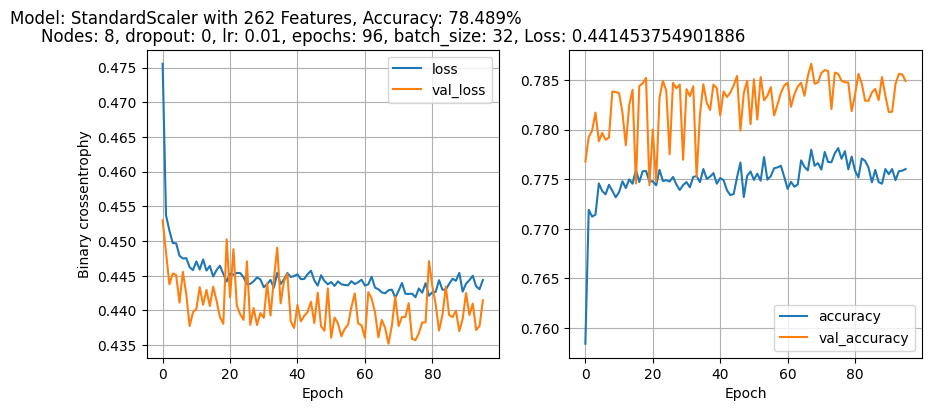

8 nodes, dropout 0, lr 0.01, batch size 64, epochs=96
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 2104      
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
________________________________________________________________

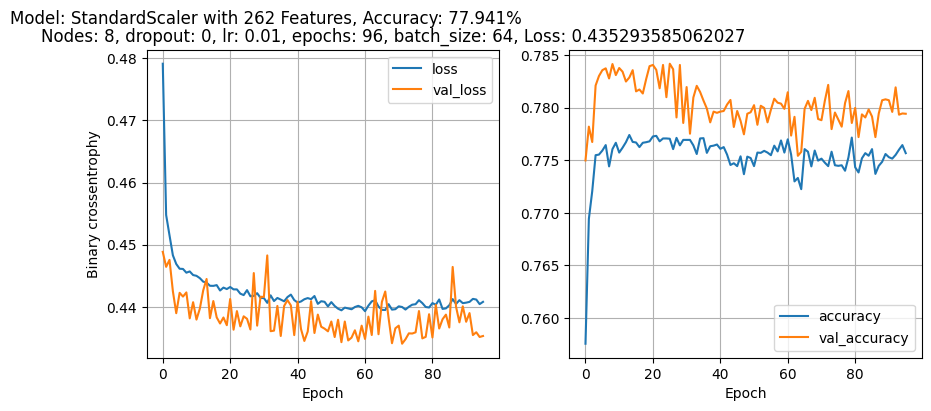

8 nodes, dropout 0, lr 0.01, batch size 128, epochs=96
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 2104      
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 8)                 72        
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
_______________________________________________________________

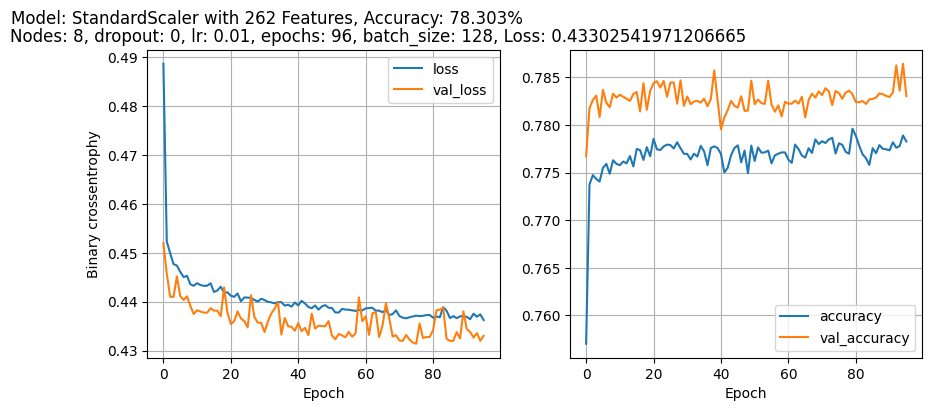

8 nodes, dropout 0, lr 0.005, batch size 32, epochs=96
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 8)                 2104      
                                                                 
 dropout_6 (Dropout)         (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 8)                 72        
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
_______________________________________________________________

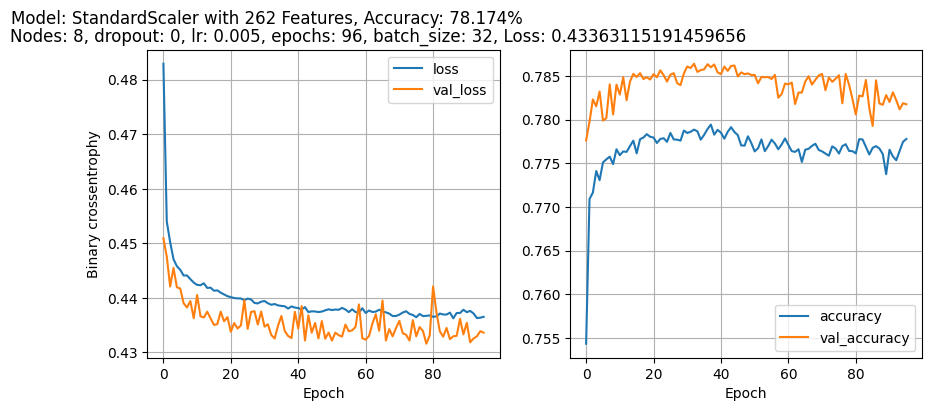

8 nodes, dropout 0, lr 0.005, batch size 64, epochs=96
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 2104      
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_13 (Dense)            (None, 8)                 72        
                                                                 
 dropout_9 (Dropout)         (None, 8)                 0         
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
_______________________________________________________________

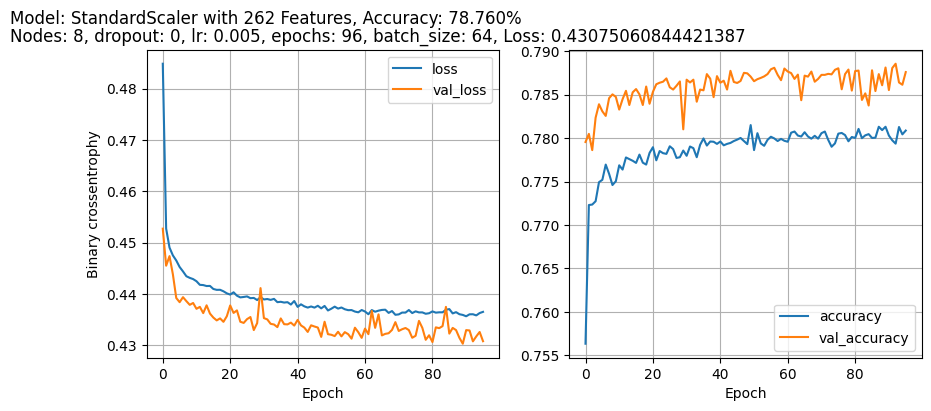

8 nodes, dropout 0, lr 0.005, batch size 128, epochs=96
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 8)                 2104      
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                                 
 dense_16 (Dense)            (None, 8)                 72        
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
______________________________________________________________

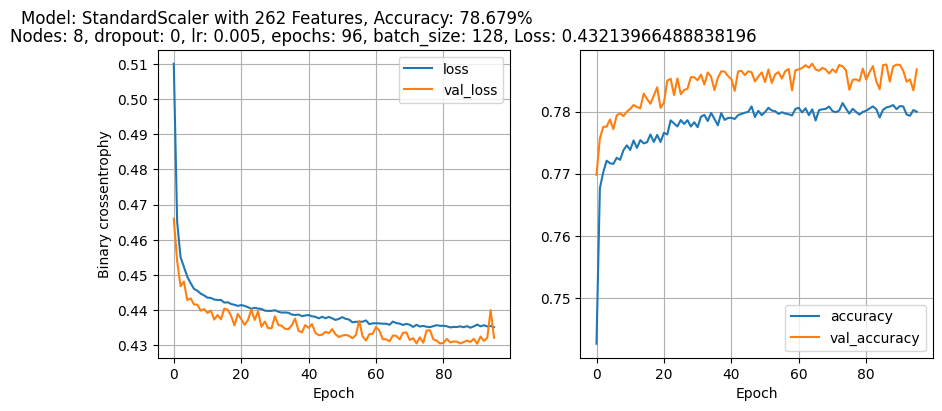

8 nodes, dropout 0, lr 0.001, batch size 32, epochs=96
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 8)                 2104      
                                                                 
 dropout_12 (Dropout)        (None, 8)                 0         
                                                                 
 dense_19 (Dense)            (None, 8)                 72        
                                                                 
 dropout_13 (Dropout)        (None, 8)                 0         
                                                                 
 dense_20 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
_______________________________________________________________

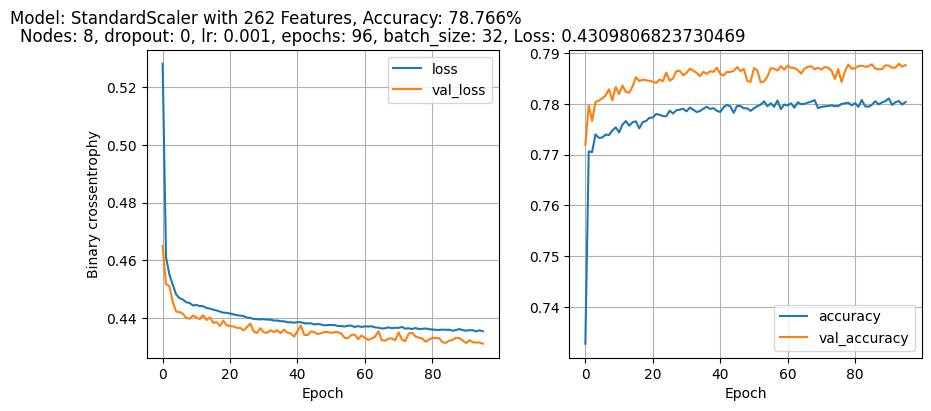

8 nodes, dropout 0, lr 0.001, batch size 64, epochs=96
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 8)                 2104      
                                                                 
 dropout_14 (Dropout)        (None, 8)                 0         
                                                                 
 dense_22 (Dense)            (None, 8)                 72        
                                                                 
 dropout_15 (Dropout)        (None, 8)                 0         
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
_______________________________________________________________

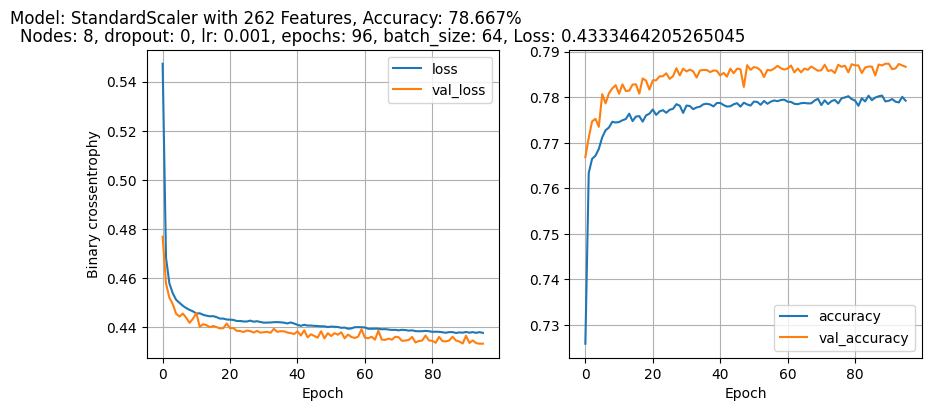

8 nodes, dropout 0, lr 0.001, batch size 128, epochs=96
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 8)                 2104      
                                                                 
 dropout_16 (Dropout)        (None, 8)                 0         
                                                                 
 dense_25 (Dense)            (None, 8)                 72        
                                                                 
 dropout_17 (Dropout)        (None, 8)                 0         
                                                                 
 dense_26 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
______________________________________________________________

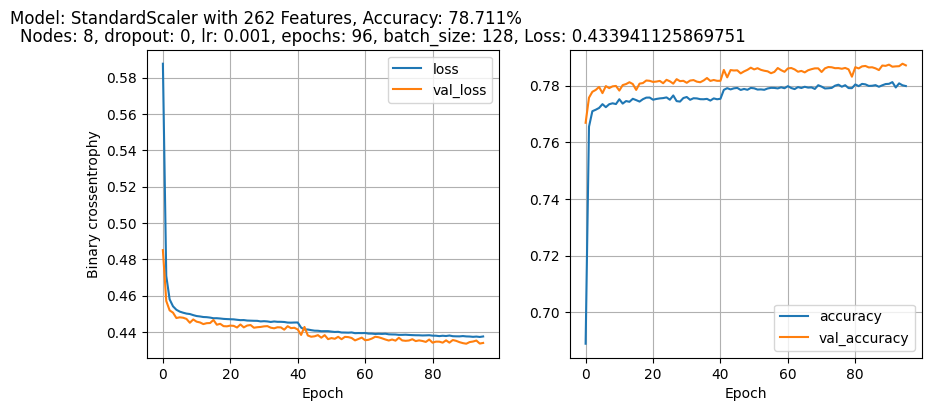

8 nodes, dropout 0.2, lr 0.01, batch size 32, epochs=96
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 8)                 2104      
                                                                 
 dropout_18 (Dropout)        (None, 8)                 0         
                                                                 
 dense_28 (Dense)            (None, 8)                 72        
                                                                 
 dropout_19 (Dropout)        (None, 8)                 0         
                                                                 
 dense_29 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
______________________________________________________________

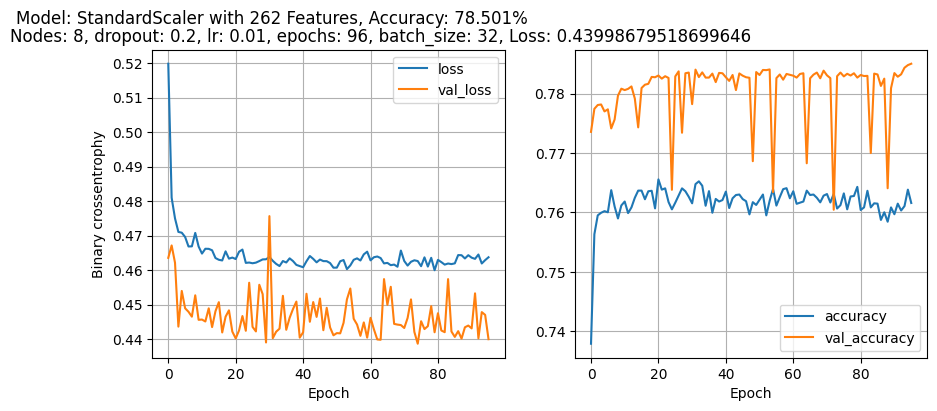

8 nodes, dropout 0.2, lr 0.01, batch size 64, epochs=96
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 8)                 2104      
                                                                 
 dropout_20 (Dropout)        (None, 8)                 0         
                                                                 
 dense_31 (Dense)            (None, 8)                 72        
                                                                 
 dropout_21 (Dropout)        (None, 8)                 0         
                                                                 
 dense_32 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
_____________________________________________________________

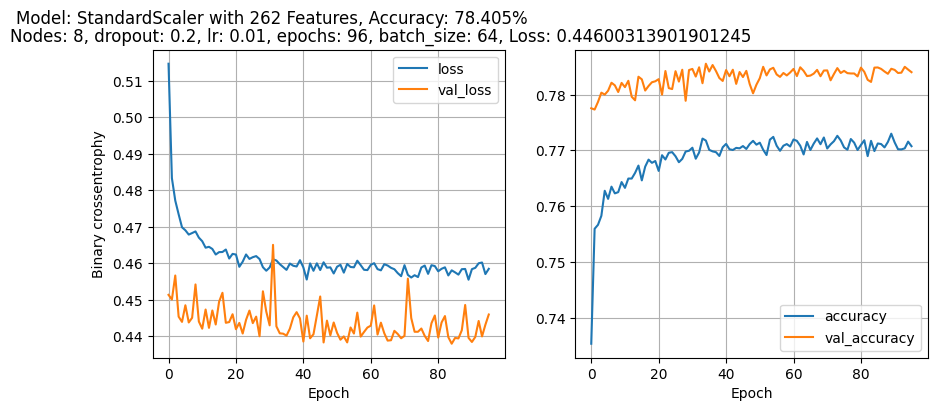

8 nodes, dropout 0.2, lr 0.01, batch size 128, epochs=96
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 8)                 2104      
                                                                 
 dropout_22 (Dropout)        (None, 8)                 0         
                                                                 
 dense_34 (Dense)            (None, 8)                 72        
                                                                 
 dropout_23 (Dropout)        (None, 8)                 0         
                                                                 
 dense_35 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
____________________________________________________________

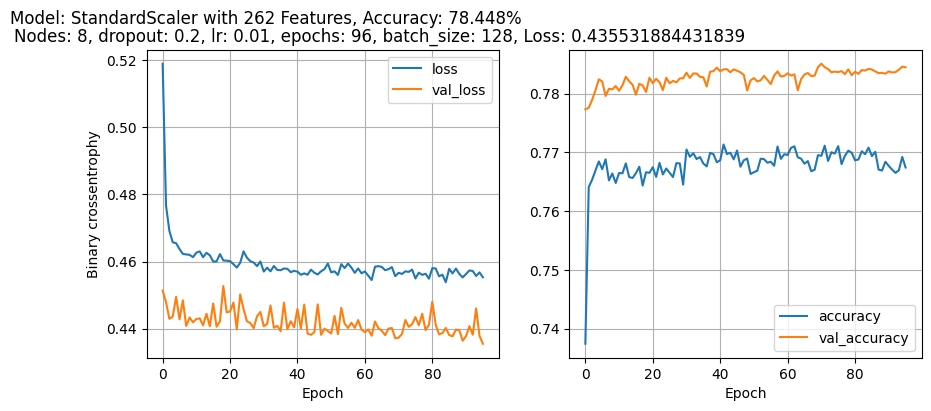

8 nodes, dropout 0.2, lr 0.005, batch size 32, epochs=96
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 8)                 2104      
                                                                 
 dropout_24 (Dropout)        (None, 8)                 0         
                                                                 
 dense_37 (Dense)            (None, 8)                 72        
                                                                 
 dropout_25 (Dropout)        (None, 8)                 0         
                                                                 
 dense_38 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
____________________________________________________________

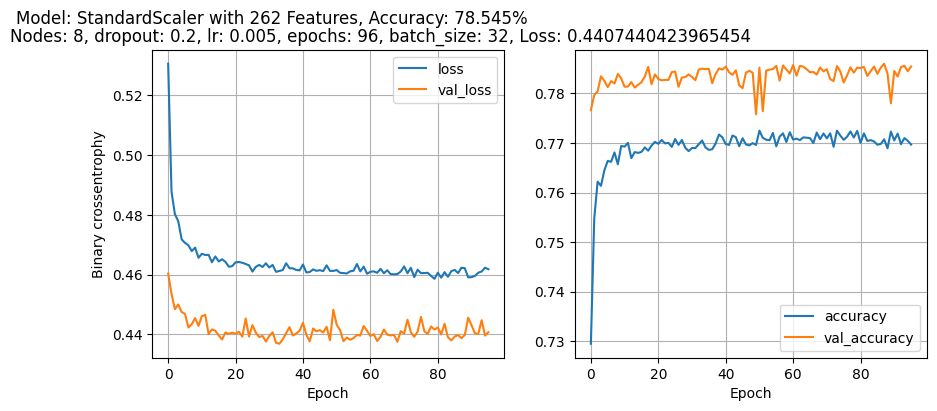

8 nodes, dropout 0.2, lr 0.005, batch size 64, epochs=96
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 8)                 2104      
                                                                 
 dropout_26 (Dropout)        (None, 8)                 0         
                                                                 
 dense_40 (Dense)            (None, 8)                 72        
                                                                 
 dropout_27 (Dropout)        (None, 8)                 0         
                                                                 
 dense_41 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
____________________________________________________________

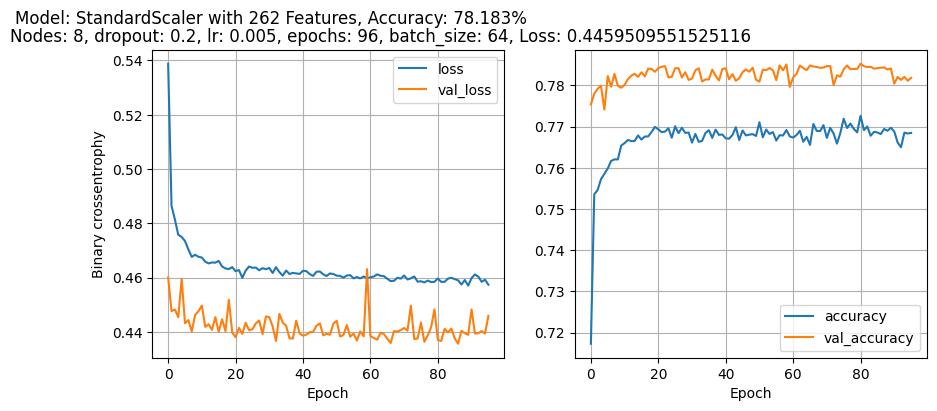

8 nodes, dropout 0.2, lr 0.005, batch size 128, epochs=96
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 8)                 2104      
                                                                 
 dropout_28 (Dropout)        (None, 8)                 0         
                                                                 
 dense_43 (Dense)            (None, 8)                 72        
                                                                 
 dropout_29 (Dropout)        (None, 8)                 0         
                                                                 
 dense_44 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
___________________________________________________________

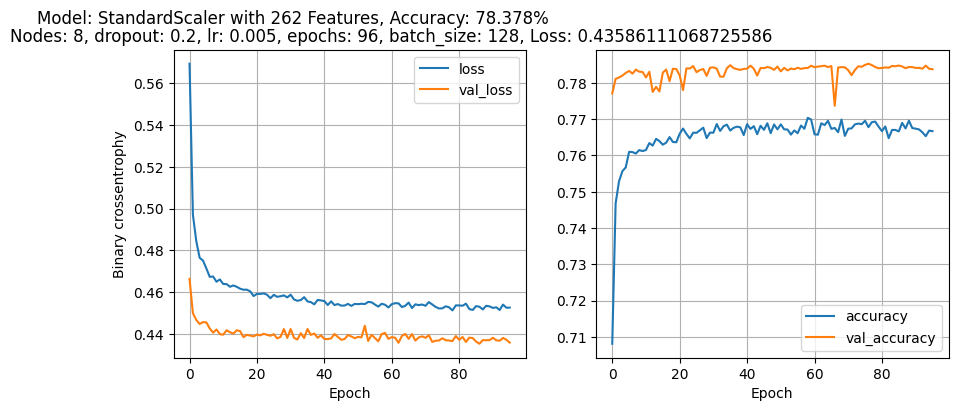

8 nodes, dropout 0.2, lr 0.001, batch size 32, epochs=96
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 8)                 2104      
                                                                 
 dropout_30 (Dropout)        (None, 8)                 0         
                                                                 
 dense_46 (Dense)            (None, 8)                 72        
                                                                 
 dropout_31 (Dropout)        (None, 8)                 0         
                                                                 
 dense_47 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
____________________________________________________________

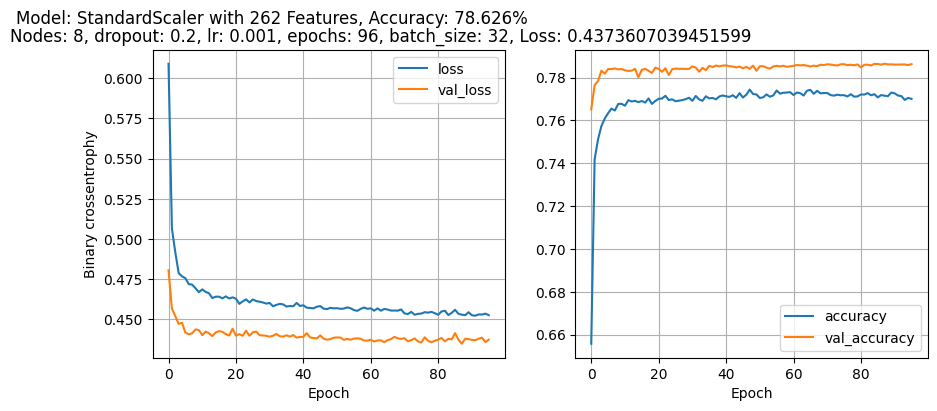

8 nodes, dropout 0.2, lr 0.001, batch size 64, epochs=96
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 8)                 2104      
                                                                 
 dropout_32 (Dropout)        (None, 8)                 0         
                                                                 
 dense_49 (Dense)            (None, 8)                 72        
                                                                 
 dropout_33 (Dropout)        (None, 8)                 0         
                                                                 
 dense_50 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
____________________________________________________________

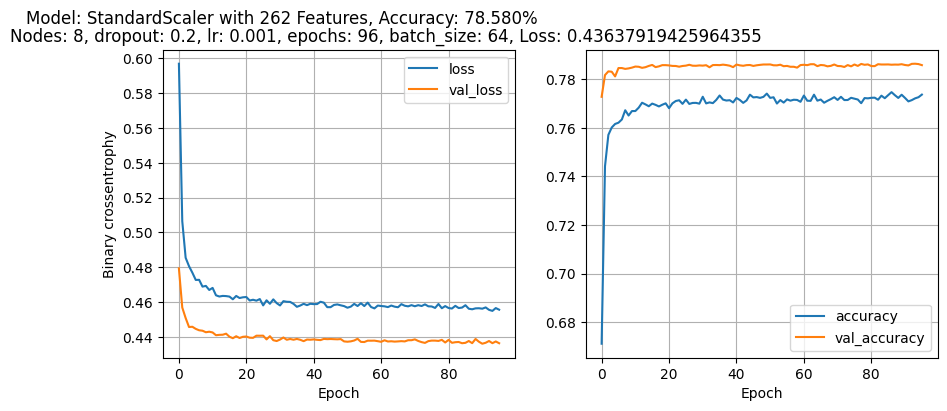

8 nodes, dropout 0.2, lr 0.001, batch size 128, epochs=96
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 8)                 2104      
                                                                 
 dropout_34 (Dropout)        (None, 8)                 0         
                                                                 
 dense_52 (Dense)            (None, 8)                 72        
                                                                 
 dropout_35 (Dropout)        (None, 8)                 0         
                                                                 
 dense_53 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
___________________________________________________________

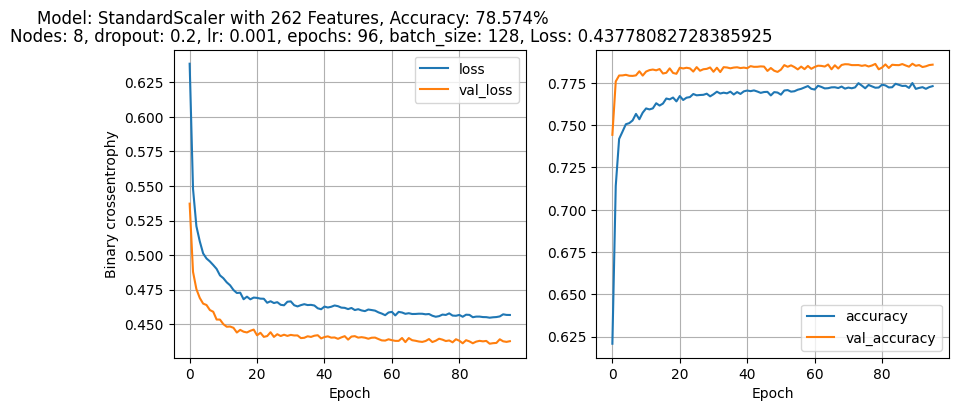

16 nodes, dropout 0, lr 0.01, batch size 32, epochs=96
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 16)                4208      
                                                                 
 dropout_36 (Dropout)        (None, 16)                0         
                                                                 
 dense_55 (Dense)            (None, 16)                272       
                                                                 
 dropout_37 (Dropout)        (None, 16)                0         
                                                                 
 dense_56 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
______________________________________________________________

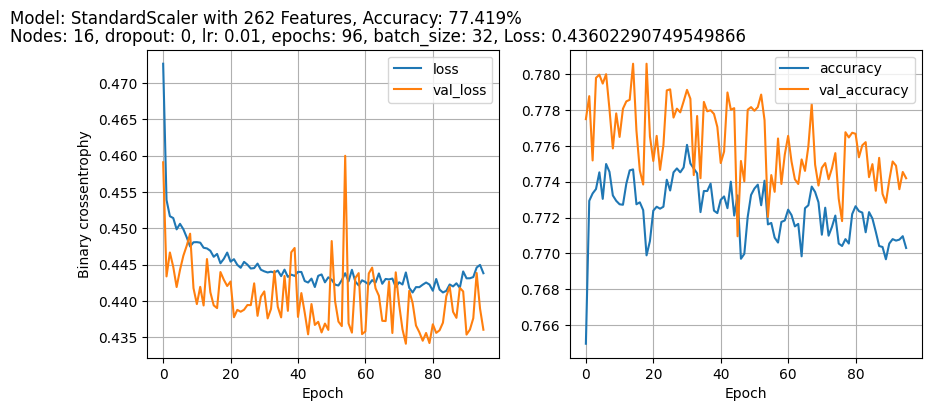

16 nodes, dropout 0, lr 0.01, batch size 64, epochs=96
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 16)                4208      
                                                                 
 dropout_38 (Dropout)        (None, 16)                0         
                                                                 
 dense_58 (Dense)            (None, 16)                272       
                                                                 
 dropout_39 (Dropout)        (None, 16)                0         
                                                                 
 dense_59 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
______________________________________________________________

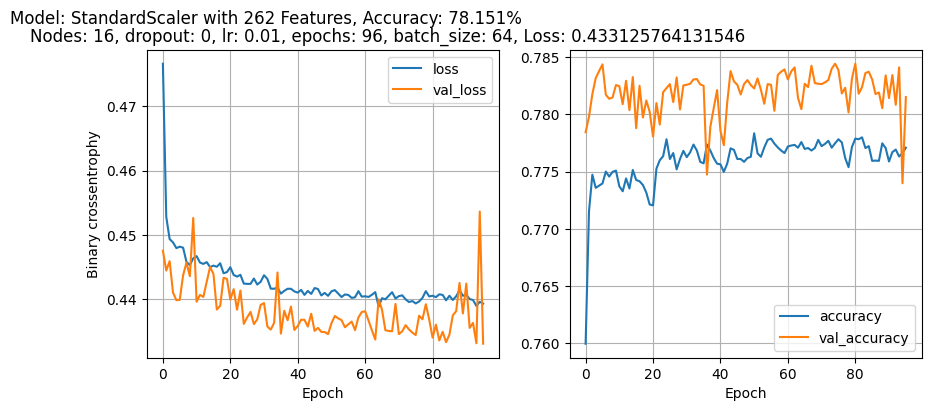

16 nodes, dropout 0, lr 0.01, batch size 128, epochs=96
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 16)                4208      
                                                                 
 dropout_40 (Dropout)        (None, 16)                0         
                                                                 
 dense_61 (Dense)            (None, 16)                272       
                                                                 
 dropout_41 (Dropout)        (None, 16)                0         
                                                                 
 dense_62 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
_____________________________________________________________

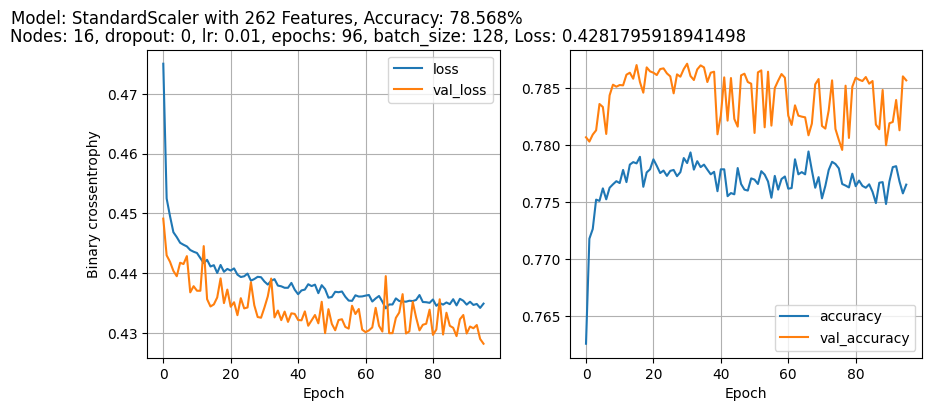

16 nodes, dropout 0, lr 0.005, batch size 32, epochs=96
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 16)                4208      
                                                                 
 dropout_42 (Dropout)        (None, 16)                0         
                                                                 
 dense_64 (Dense)            (None, 16)                272       
                                                                 
 dropout_43 (Dropout)        (None, 16)                0         
                                                                 
 dense_65 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
_____________________________________________________________

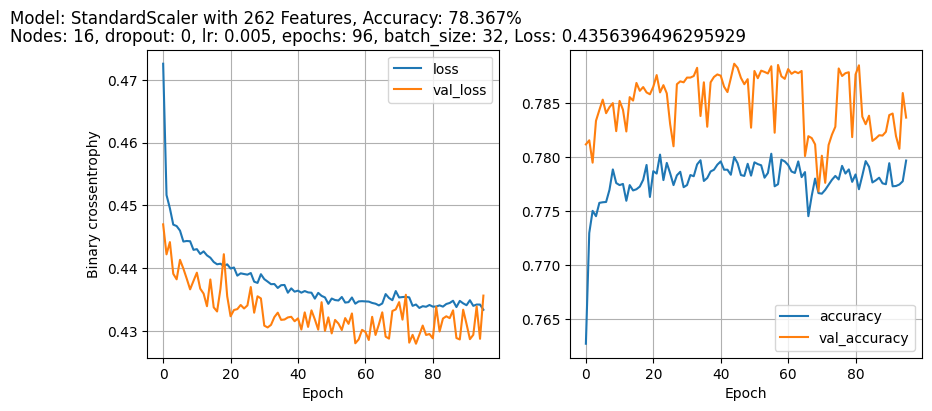

16 nodes, dropout 0, lr 0.005, batch size 64, epochs=96
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 16)                4208      
                                                                 
 dropout_44 (Dropout)        (None, 16)                0         
                                                                 
 dense_67 (Dense)            (None, 16)                272       
                                                                 
 dropout_45 (Dropout)        (None, 16)                0         
                                                                 
 dense_68 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
_____________________________________________________________

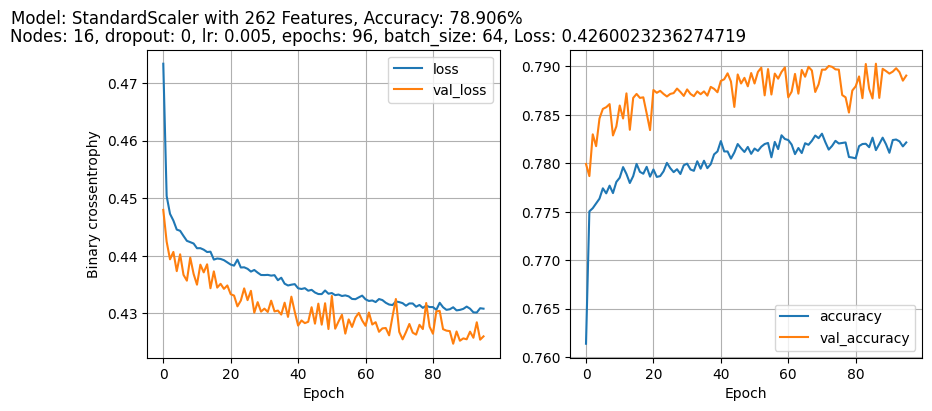

16 nodes, dropout 0, lr 0.005, batch size 128, epochs=96
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 16)                4208      
                                                                 
 dropout_46 (Dropout)        (None, 16)                0         
                                                                 
 dense_70 (Dense)            (None, 16)                272       
                                                                 
 dropout_47 (Dropout)        (None, 16)                0         
                                                                 
 dense_71 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
____________________________________________________________

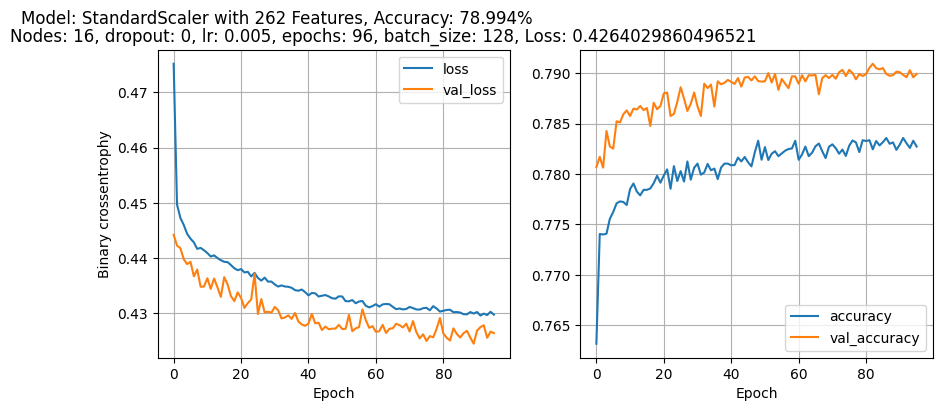

16 nodes, dropout 0, lr 0.001, batch size 32, epochs=96
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 16)                4208      
                                                                 
 dropout_48 (Dropout)        (None, 16)                0         
                                                                 
 dense_73 (Dense)            (None, 16)                272       
                                                                 
 dropout_49 (Dropout)        (None, 16)                0         
                                                                 
 dense_74 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
_____________________________________________________________

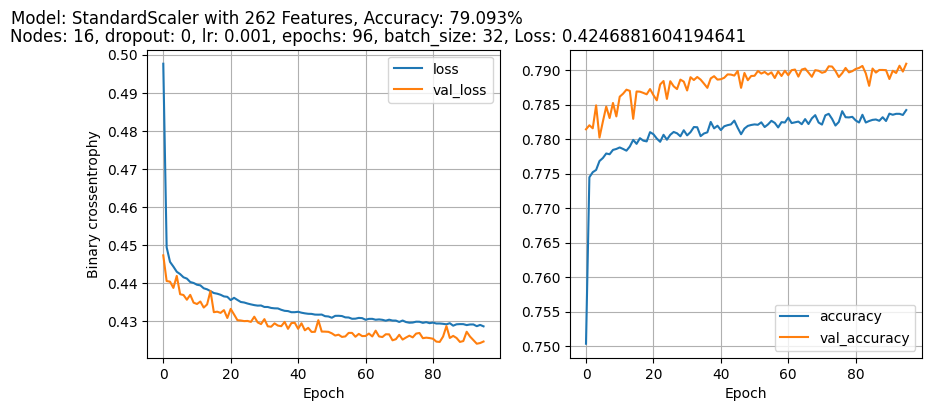

16 nodes, dropout 0, lr 0.001, batch size 64, epochs=96
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 16)                4208      
                                                                 
 dropout_50 (Dropout)        (None, 16)                0         
                                                                 
 dense_76 (Dense)            (None, 16)                272       
                                                                 
 dropout_51 (Dropout)        (None, 16)                0         
                                                                 
 dense_77 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
_____________________________________________________________

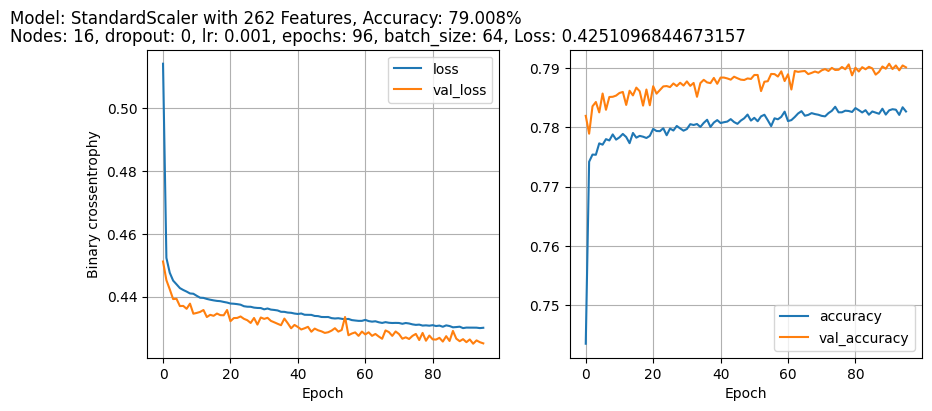

16 nodes, dropout 0, lr 0.001, batch size 128, epochs=96
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 16)                4208      
                                                                 
 dropout_52 (Dropout)        (None, 16)                0         
                                                                 
 dense_79 (Dense)            (None, 16)                272       
                                                                 
 dropout_53 (Dropout)        (None, 16)                0         
                                                                 
 dense_80 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
____________________________________________________________

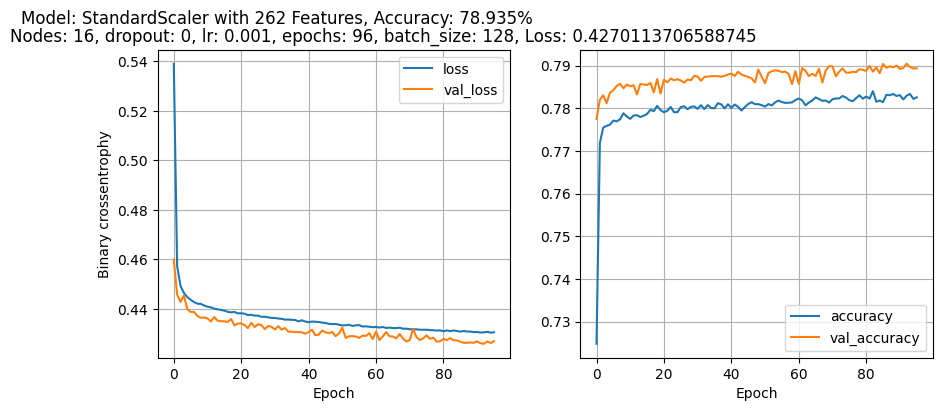

16 nodes, dropout 0.2, lr 0.01, batch size 32, epochs=96
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 16)                4208      
                                                                 
 dropout_54 (Dropout)        (None, 16)                0         
                                                                 
 dense_82 (Dense)            (None, 16)                272       
                                                                 
 dropout_55 (Dropout)        (None, 16)                0         
                                                                 
 dense_83 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
____________________________________________________________

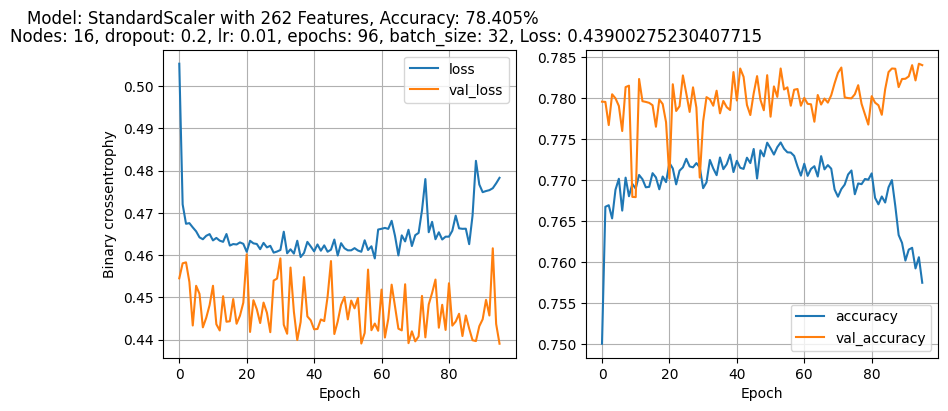

16 nodes, dropout 0.2, lr 0.01, batch size 64, epochs=96
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 16)                4208      
                                                                 
 dropout_56 (Dropout)        (None, 16)                0         
                                                                 
 dense_85 (Dense)            (None, 16)                272       
                                                                 
 dropout_57 (Dropout)        (None, 16)                0         
                                                                 
 dense_86 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
____________________________________________________________

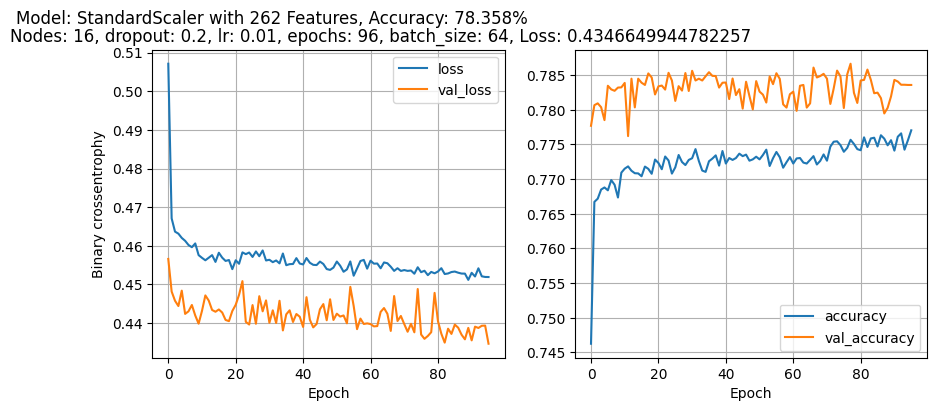

16 nodes, dropout 0.2, lr 0.01, batch size 128, epochs=96
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 16)                4208      
                                                                 
 dropout_58 (Dropout)        (None, 16)                0         
                                                                 
 dense_88 (Dense)            (None, 16)                272       
                                                                 
 dropout_59 (Dropout)        (None, 16)                0         
                                                                 
 dense_89 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
___________________________________________________________

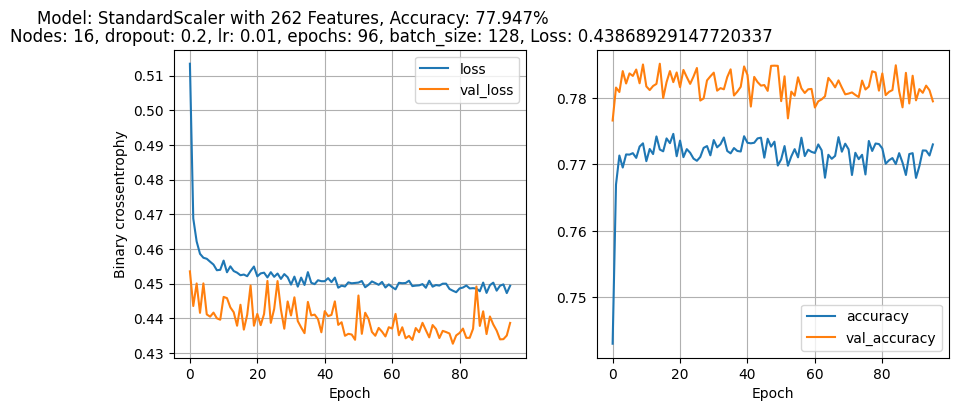

16 nodes, dropout 0.2, lr 0.005, batch size 32, epochs=96
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 16)                4208      
                                                                 
 dropout_60 (Dropout)        (None, 16)                0         
                                                                 
 dense_91 (Dense)            (None, 16)                272       
                                                                 
 dropout_61 (Dropout)        (None, 16)                0         
                                                                 
 dense_92 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
___________________________________________________________

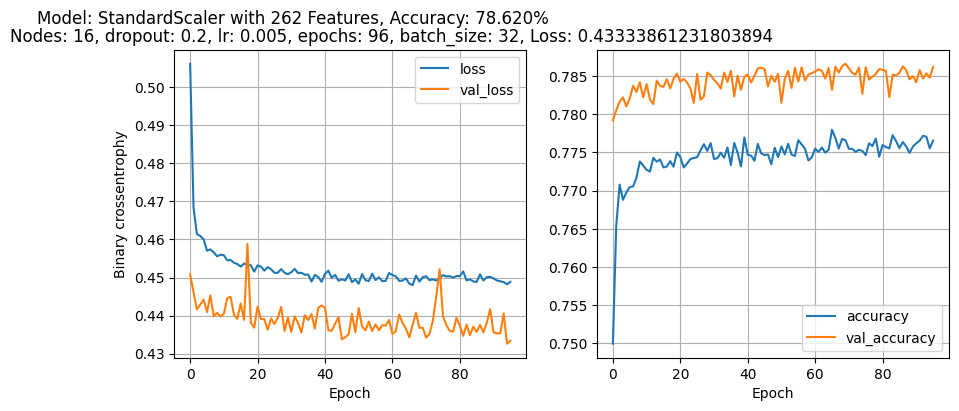

16 nodes, dropout 0.2, lr 0.005, batch size 64, epochs=96
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 16)                4208      
                                                                 
 dropout_62 (Dropout)        (None, 16)                0         
                                                                 
 dense_94 (Dense)            (None, 16)                272       
                                                                 
 dropout_63 (Dropout)        (None, 16)                0         
                                                                 
 dense_95 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
___________________________________________________________

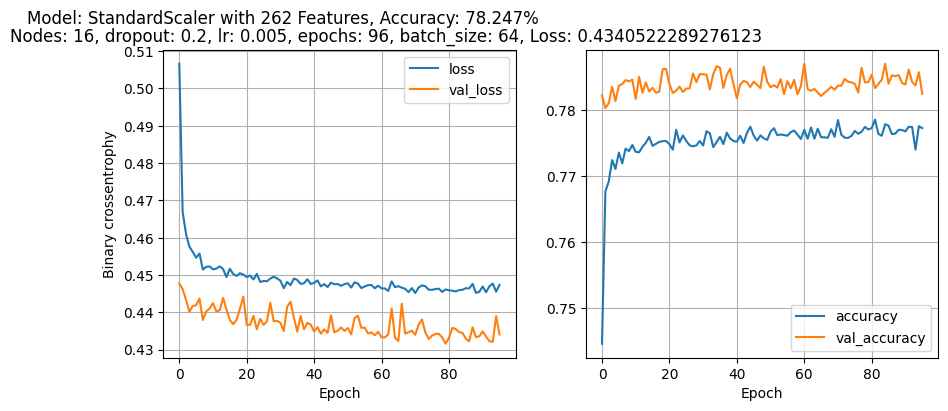

16 nodes, dropout 0.2, lr 0.005, batch size 128, epochs=96
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 16)                4208      
                                                                 
 dropout_64 (Dropout)        (None, 16)                0         
                                                                 
 dense_97 (Dense)            (None, 16)                272       
                                                                 
 dropout_65 (Dropout)        (None, 16)                0         
                                                                 
 dense_98 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
__________________________________________________________

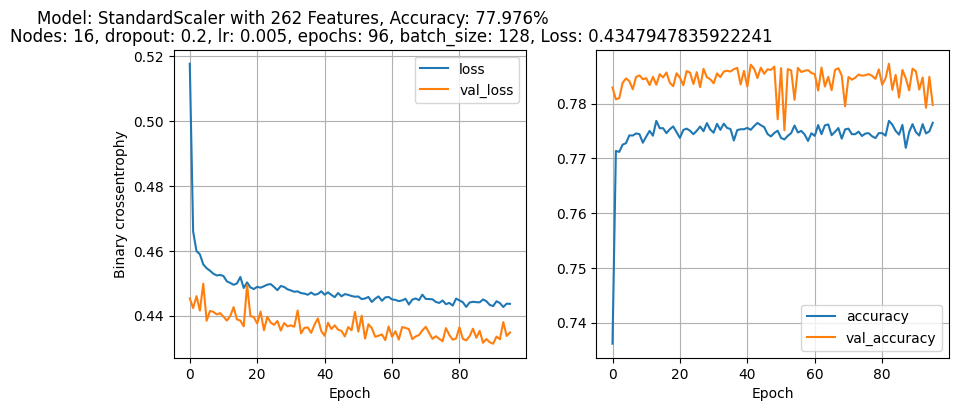

16 nodes, dropout 0.2, lr 0.001, batch size 32, epochs=96
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 16)                4208      
                                                                 
 dropout_66 (Dropout)        (None, 16)                0         
                                                                 
 dense_100 (Dense)           (None, 16)                272       
                                                                 
 dropout_67 (Dropout)        (None, 16)                0         
                                                                 
 dense_101 (Dense)           (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
___________________________________________________________

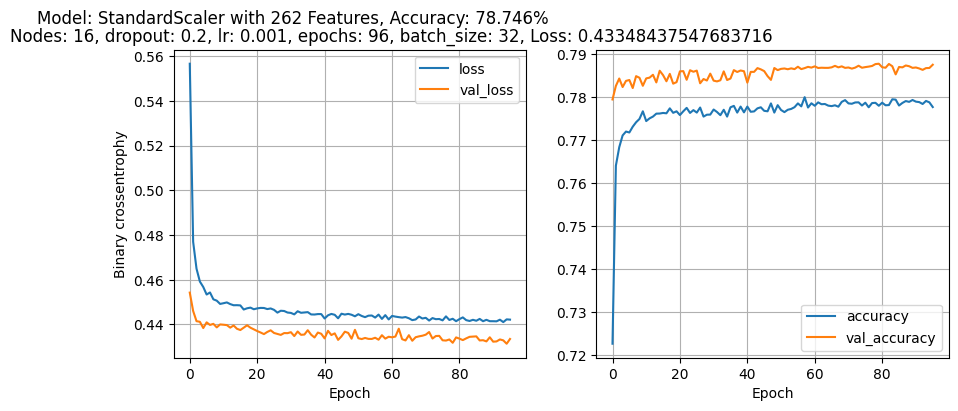

16 nodes, dropout 0.2, lr 0.001, batch size 64, epochs=96
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 16)                4208      
                                                                 
 dropout_68 (Dropout)        (None, 16)                0         
                                                                 
 dense_103 (Dense)           (None, 16)                272       
                                                                 
 dropout_69 (Dropout)        (None, 16)                0         
                                                                 
 dense_104 (Dense)           (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
___________________________________________________________

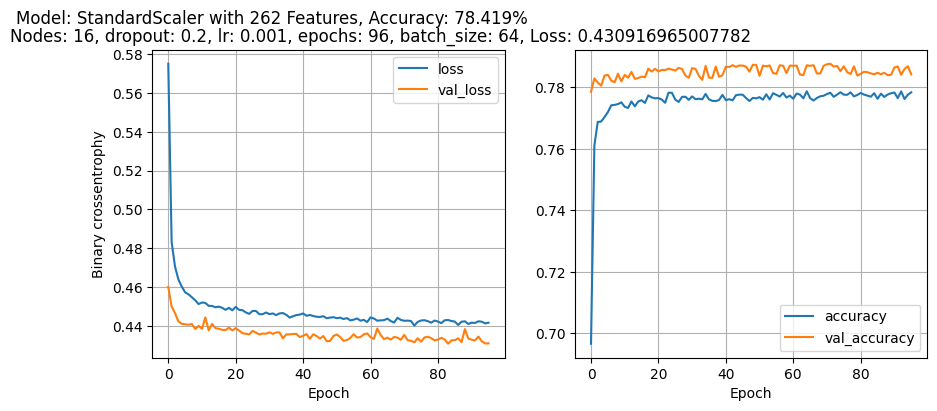

16 nodes, dropout 0.2, lr 0.001, batch size 128, epochs=96
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 16)                4208      
                                                                 
 dropout_70 (Dropout)        (None, 16)                0         
                                                                 
 dense_106 (Dense)           (None, 16)                272       
                                                                 
 dropout_71 (Dropout)        (None, 16)                0         
                                                                 
 dense_107 (Dense)           (None, 1)                 17        
                                                                 
Total params: 4,497
Trainable params: 4,497
Non-trainable params: 0
__________________________________________________________

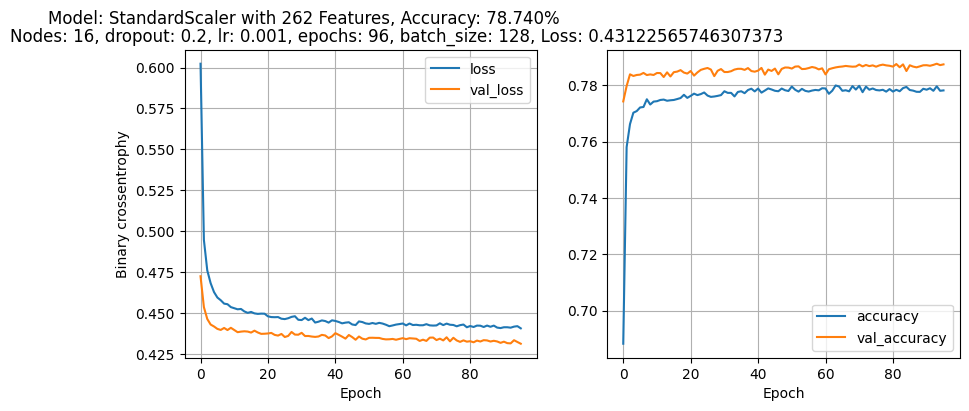

24 nodes, dropout 0, lr 0.01, batch size 32, epochs=96
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 24)                6312      
                                                                 
 dropout_72 (Dropout)        (None, 24)                0         
                                                                 
 dense_109 (Dense)           (None, 24)                600       
                                                                 
 dropout_73 (Dropout)        (None, 24)                0         
                                                                 
 dense_110 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
______________________________________________________________

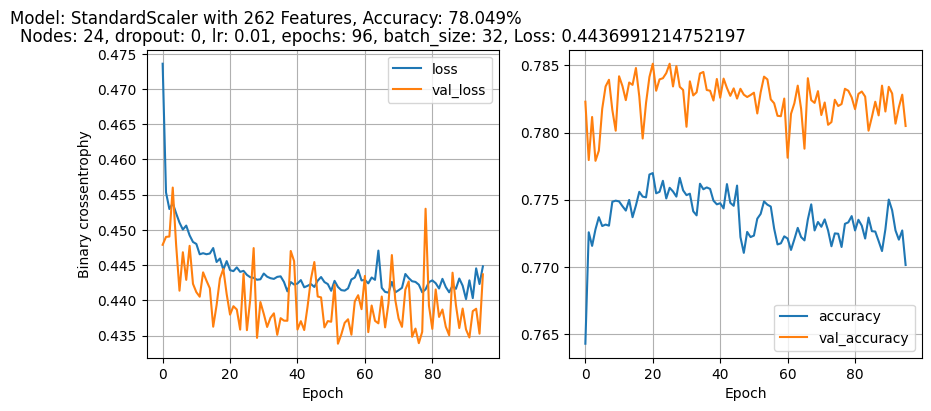

24 nodes, dropout 0, lr 0.01, batch size 64, epochs=96
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_111 (Dense)           (None, 24)                6312      
                                                                 
 dropout_74 (Dropout)        (None, 24)                0         
                                                                 
 dense_112 (Dense)           (None, 24)                600       
                                                                 
 dropout_75 (Dropout)        (None, 24)                0         
                                                                 
 dense_113 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
______________________________________________________________

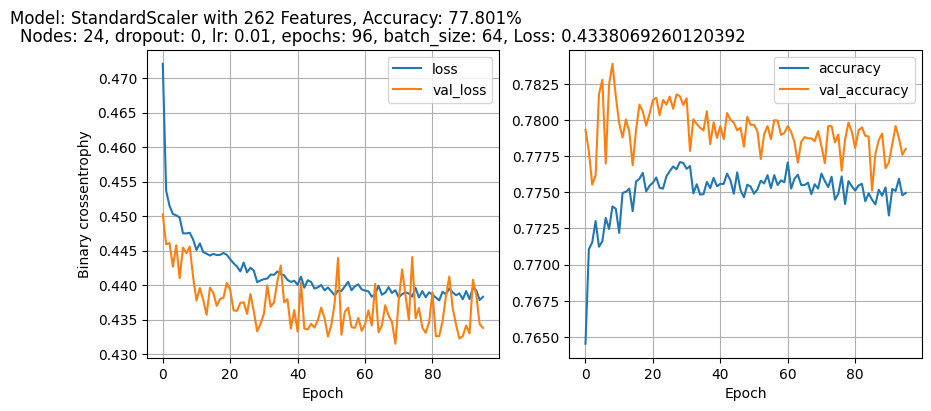

24 nodes, dropout 0, lr 0.01, batch size 128, epochs=96
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 24)                6312      
                                                                 
 dropout_76 (Dropout)        (None, 24)                0         
                                                                 
 dense_115 (Dense)           (None, 24)                600       
                                                                 
 dropout_77 (Dropout)        (None, 24)                0         
                                                                 
 dense_116 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
_____________________________________________________________

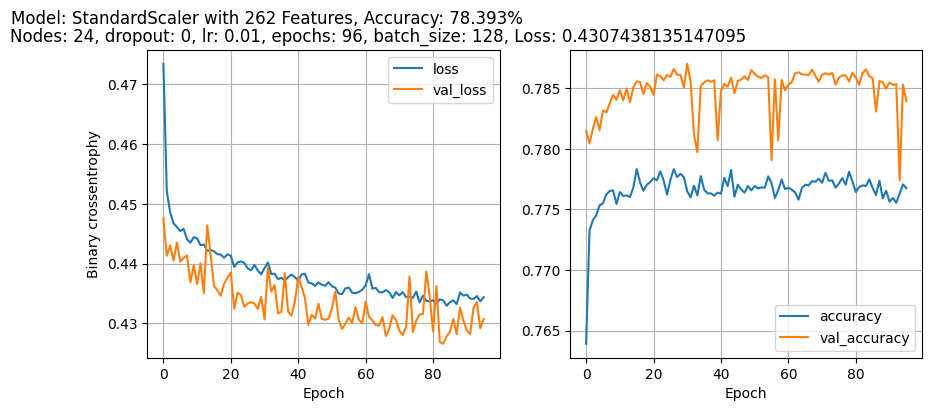

24 nodes, dropout 0, lr 0.005, batch size 32, epochs=96
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 24)                6312      
                                                                 
 dropout_78 (Dropout)        (None, 24)                0         
                                                                 
 dense_118 (Dense)           (None, 24)                600       
                                                                 
 dropout_79 (Dropout)        (None, 24)                0         
                                                                 
 dense_119 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
_____________________________________________________________

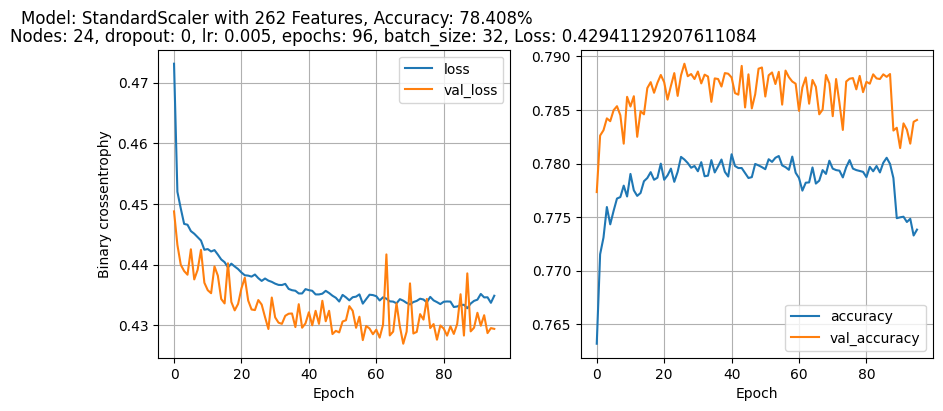

24 nodes, dropout 0, lr 0.005, batch size 64, epochs=96
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 24)                6312      
                                                                 
 dropout_80 (Dropout)        (None, 24)                0         
                                                                 
 dense_121 (Dense)           (None, 24)                600       
                                                                 
 dropout_81 (Dropout)        (None, 24)                0         
                                                                 
 dense_122 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
_____________________________________________________________

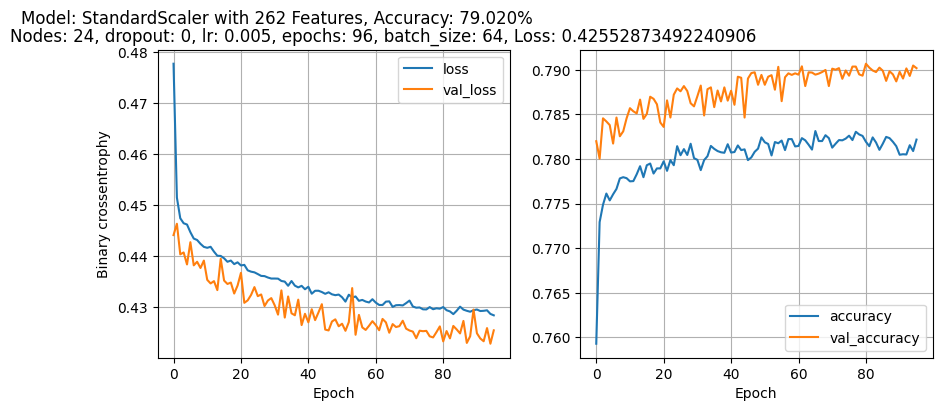

24 nodes, dropout 0, lr 0.005, batch size 128, epochs=96
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_123 (Dense)           (None, 24)                6312      
                                                                 
 dropout_82 (Dropout)        (None, 24)                0         
                                                                 
 dense_124 (Dense)           (None, 24)                600       
                                                                 
 dropout_83 (Dropout)        (None, 24)                0         
                                                                 
 dense_125 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
____________________________________________________________

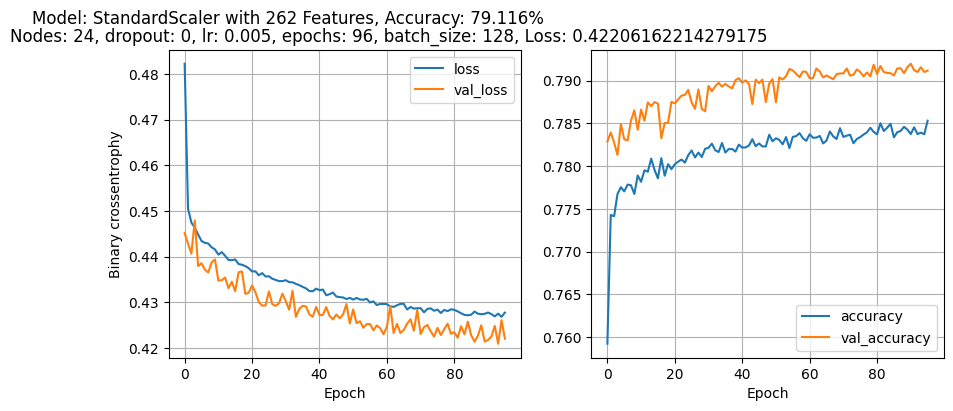

24 nodes, dropout 0, lr 0.001, batch size 32, epochs=96
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_126 (Dense)           (None, 24)                6312      
                                                                 
 dropout_84 (Dropout)        (None, 24)                0         
                                                                 
 dense_127 (Dense)           (None, 24)                600       
                                                                 
 dropout_85 (Dropout)        (None, 24)                0         
                                                                 
 dense_128 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
_____________________________________________________________

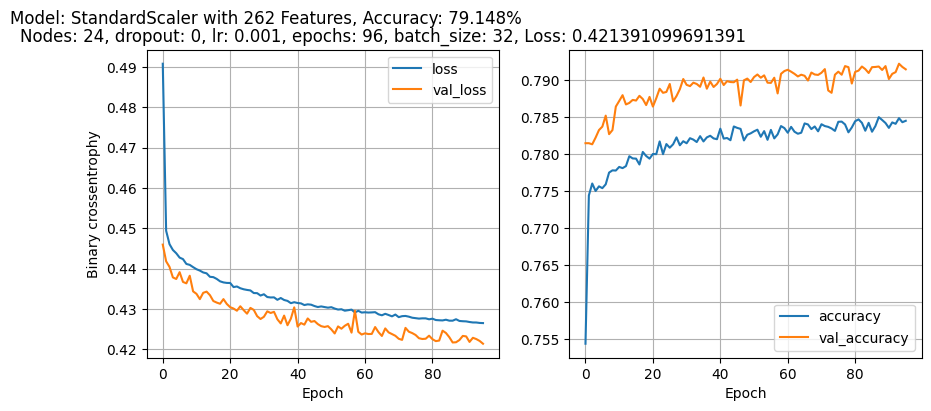

24 nodes, dropout 0, lr 0.001, batch size 64, epochs=96
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129 (Dense)           (None, 24)                6312      
                                                                 
 dropout_86 (Dropout)        (None, 24)                0         
                                                                 
 dense_130 (Dense)           (None, 24)                600       
                                                                 
 dropout_87 (Dropout)        (None, 24)                0         
                                                                 
 dense_131 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
_____________________________________________________________

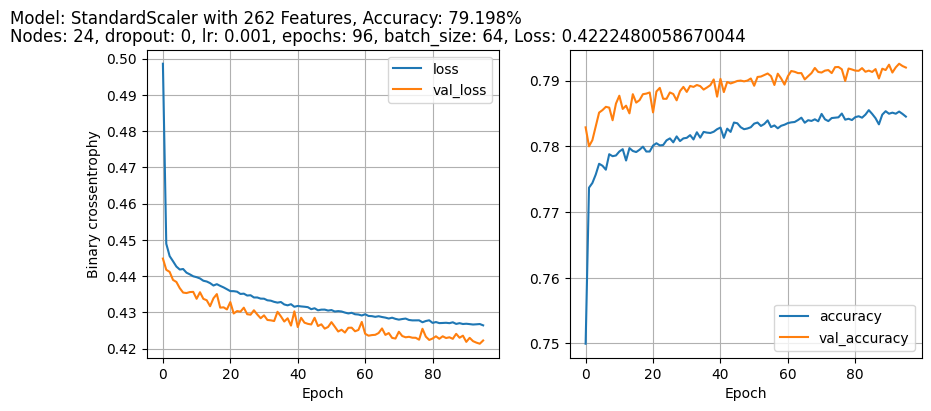

24 nodes, dropout 0, lr 0.001, batch size 128, epochs=96
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 24)                6312      
                                                                 
 dropout_88 (Dropout)        (None, 24)                0         
                                                                 
 dense_133 (Dense)           (None, 24)                600       
                                                                 
 dropout_89 (Dropout)        (None, 24)                0         
                                                                 
 dense_134 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
____________________________________________________________

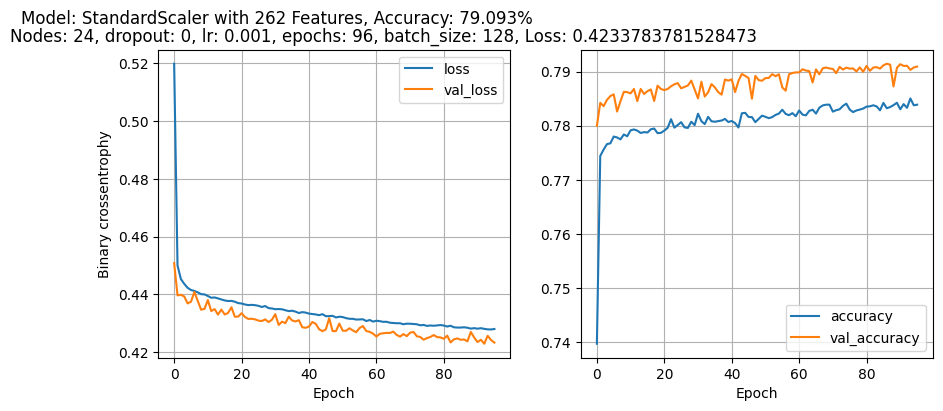

24 nodes, dropout 0.2, lr 0.01, batch size 32, epochs=96
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_135 (Dense)           (None, 24)                6312      
                                                                 
 dropout_90 (Dropout)        (None, 24)                0         
                                                                 
 dense_136 (Dense)           (None, 24)                600       
                                                                 
 dropout_91 (Dropout)        (None, 24)                0         
                                                                 
 dense_137 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
____________________________________________________________

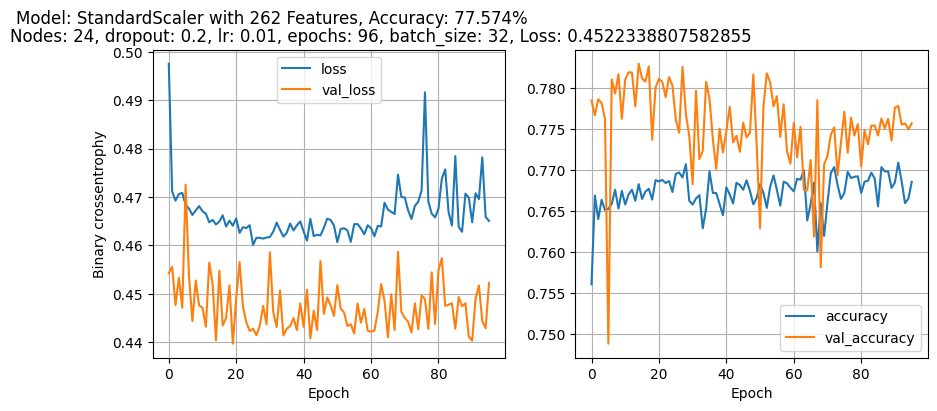

24 nodes, dropout 0.2, lr 0.01, batch size 64, epochs=96
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138 (Dense)           (None, 24)                6312      
                                                                 
 dropout_92 (Dropout)        (None, 24)                0         
                                                                 
 dense_139 (Dense)           (None, 24)                600       
                                                                 
 dropout_93 (Dropout)        (None, 24)                0         
                                                                 
 dense_140 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
____________________________________________________________

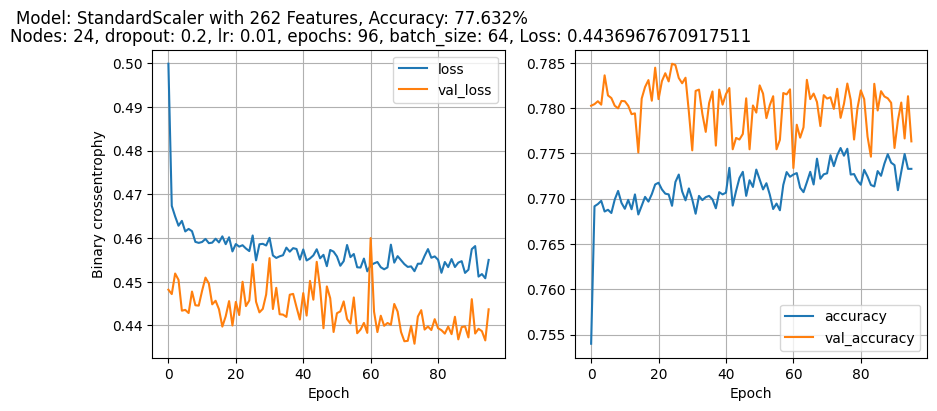

24 nodes, dropout 0.2, lr 0.01, batch size 128, epochs=96
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_141 (Dense)           (None, 24)                6312      
                                                                 
 dropout_94 (Dropout)        (None, 24)                0         
                                                                 
 dense_142 (Dense)           (None, 24)                600       
                                                                 
 dropout_95 (Dropout)        (None, 24)                0         
                                                                 
 dense_143 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
___________________________________________________________

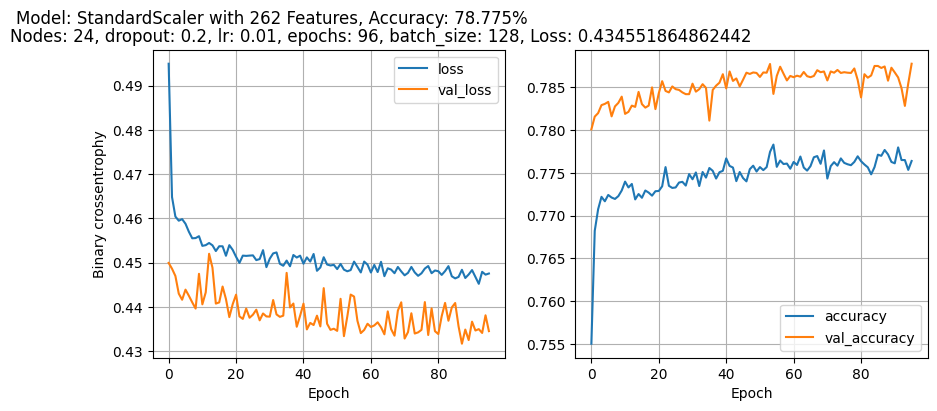

24 nodes, dropout 0.2, lr 0.005, batch size 32, epochs=96
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 24)                6312      
                                                                 
 dropout_96 (Dropout)        (None, 24)                0         
                                                                 
 dense_145 (Dense)           (None, 24)                600       
                                                                 
 dropout_97 (Dropout)        (None, 24)                0         
                                                                 
 dense_146 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
___________________________________________________________

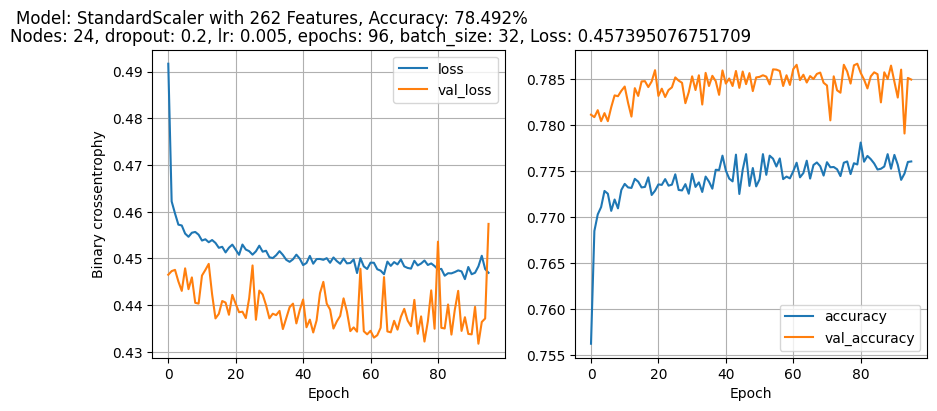

24 nodes, dropout 0.2, lr 0.005, batch size 64, epochs=96
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 24)                6312      
                                                                 
 dropout_98 (Dropout)        (None, 24)                0         
                                                                 
 dense_148 (Dense)           (None, 24)                600       
                                                                 
 dropout_99 (Dropout)        (None, 24)                0         
                                                                 
 dense_149 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
___________________________________________________________

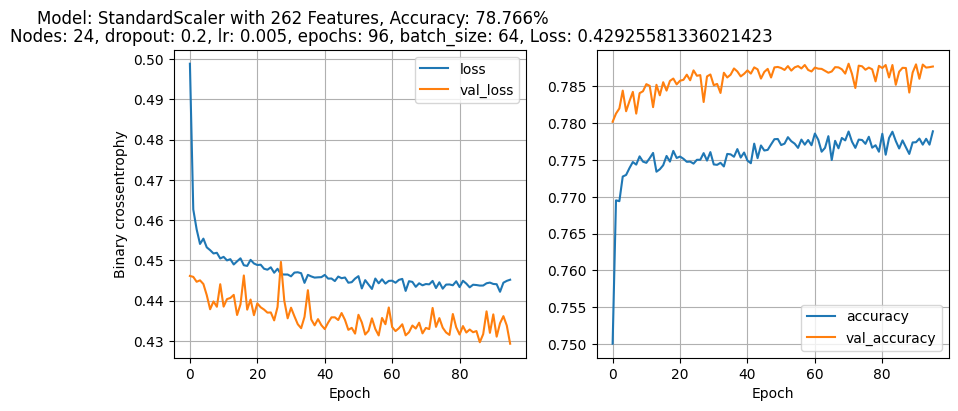

24 nodes, dropout 0.2, lr 0.005, batch size 128, epochs=96
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, 24)                6312      
                                                                 
 dropout_100 (Dropout)       (None, 24)                0         
                                                                 
 dense_151 (Dense)           (None, 24)                600       
                                                                 
 dropout_101 (Dropout)       (None, 24)                0         
                                                                 
 dense_152 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
__________________________________________________________

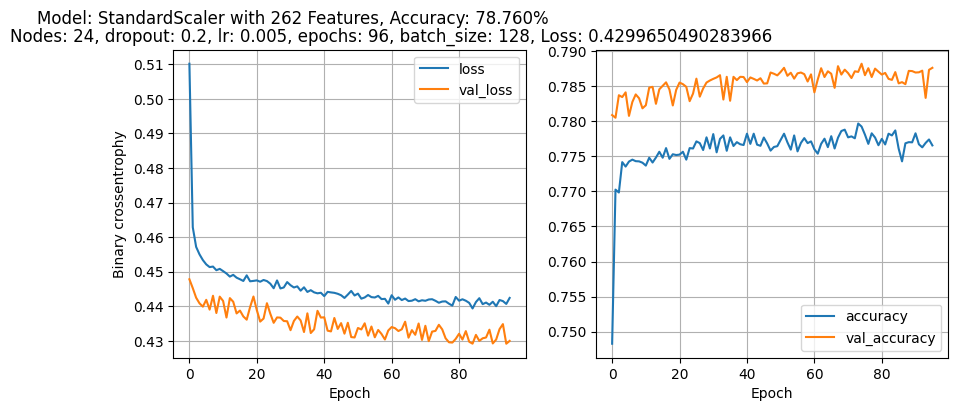

24 nodes, dropout 0.2, lr 0.001, batch size 32, epochs=96
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_153 (Dense)           (None, 24)                6312      
                                                                 
 dropout_102 (Dropout)       (None, 24)                0         
                                                                 
 dense_154 (Dense)           (None, 24)                600       
                                                                 
 dropout_103 (Dropout)       (None, 24)                0         
                                                                 
 dense_155 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
___________________________________________________________

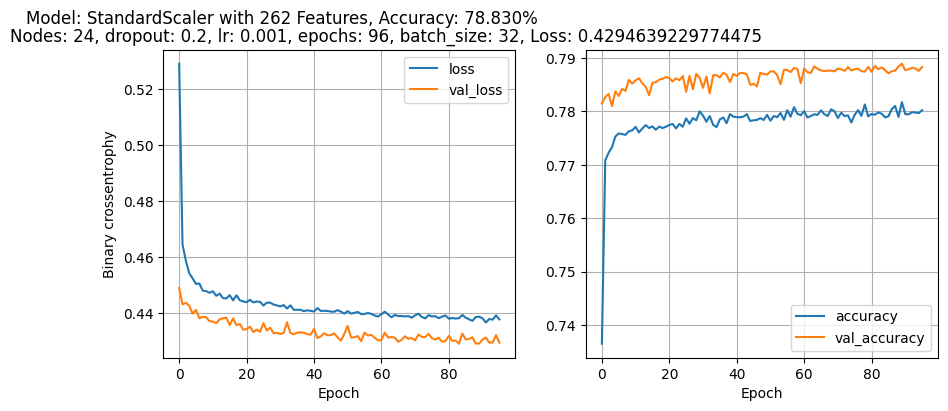

24 nodes, dropout 0.2, lr 0.001, batch size 64, epochs=96
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 24)                6312      
                                                                 
 dropout_104 (Dropout)       (None, 24)                0         
                                                                 
 dense_157 (Dense)           (None, 24)                600       
                                                                 
 dropout_105 (Dropout)       (None, 24)                0         
                                                                 
 dense_158 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
___________________________________________________________

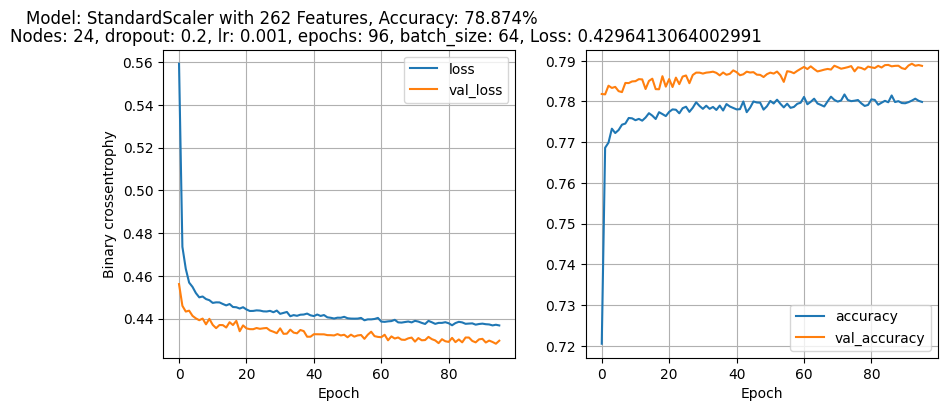

24 nodes, dropout 0.2, lr 0.001, batch size 128, epochs=96
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_159 (Dense)           (None, 24)                6312      
                                                                 
 dropout_106 (Dropout)       (None, 24)                0         
                                                                 
 dense_160 (Dense)           (None, 24)                600       
                                                                 
 dropout_107 (Dropout)       (None, 24)                0         
                                                                 
 dense_161 (Dense)           (None, 1)                 25        
                                                                 
Total params: 6,937
Trainable params: 6,937
Non-trainable params: 0
__________________________________________________________

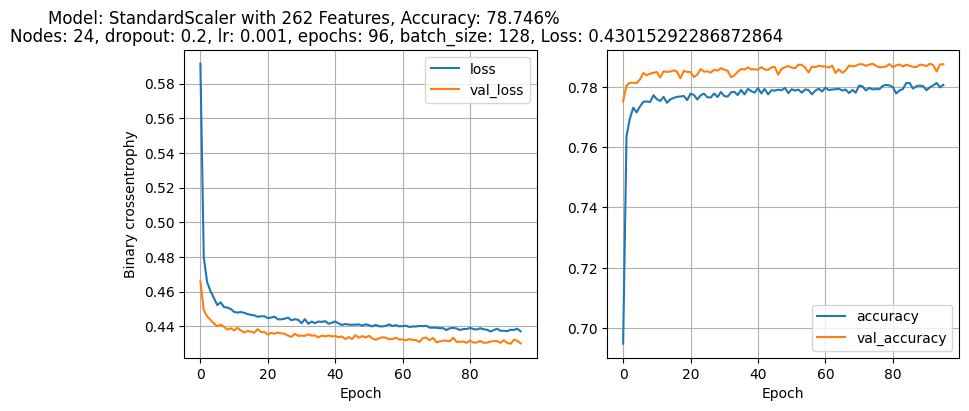

In [48]:
# set up and run model predictions
epochs = 96 
filepath = 'deep-learning-challenge/checkpoints/EXTRA_AlphabetSoupCharity.h5'

# view the loss and accuracy of model
least_val_loss = float('inf')
least_loss_model = None

for node in [8, 16, 24]:
  for dropout_probability in [0, 0.2]:
    for learning_rate in [0.01, 0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f'{node} nodes, dropout {dropout_probability}, lr {learning_rate}, batch size {batch_size}, epochs={epochs}')
        nn, history = train_model(X_train, y_train, node, dropout_probability, learning_rate, batch_size, epochs)

        # calculate loss to find least loss (best model)
        loss_acc = nn.evaluate(X_valid, y_valid)
        a_score = loss_acc[1]  # model accuracy
        l_score = loss_acc[0]  # model loss        
        plot_history(history, a_score, l_score, node, dropout_probability, learning_rate, batch_size, epochs)
        
        if l_score < least_val_loss:
          least_val_loss = l_score
          least_loss_model = nn
          tf.keras.saving.save_model(nn, filepath, overwrite=True, save_format=None)


In [49]:
# Calculate the classification report
target_names = ["Not Successful", "Successful"]

y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
print(classification_report(y_test, y_pred, target_names=target_names))

1072/1072 [==============================] - 3s 2ms/step
                precision    recall  f1-score   support

Not Successful       0.83      0.69      0.76     16038
    Successful       0.76      0.88      0.82     18261

      accuracy                           0.79     34299
     macro avg       0.80      0.79      0.79     34299
  weighted avg       0.80      0.79      0.79     34299



In [51]:
!zip -r /content/charity_modeling.zip /content/deep-learning-challenge

  adding: content/deep-learning-challenge/ (stored 0%)
  adding: content/deep-learning-challenge/README.md (deflated 50%)
  adding: content/deep-learning-challenge/Resources/ (stored 0%)
  adding: content/deep-learning-challenge/Resources/charity_data.csv (deflated 82%)
  adding: content/deep-learning-challenge/.git/ (stored 0%)
  adding: content/deep-learning-challenge/.git/HEAD (stored 0%)
  adding: content/deep-learning-challenge/.git/refs/ (stored 0%)
  adding: content/deep-learning-challenge/.git/refs/tags/ (stored 0%)
  adding: content/deep-learning-challenge/.git/refs/remotes/ (stored 0%)
  adding: content/deep-learning-challenge/.git/refs/remotes/origin/ (stored 0%)
  adding: content/deep-learning-challenge/.git/refs/remotes/origin/HEAD (stored 0%)
  adding: content/deep-learning-challenge/.git/refs/heads/ (stored 0%)
  adding: content/deep-learning-challenge/.git/refs/heads/main (stored 0%)
  adding: content/deep-learning-challenge/.git/logs/ (stored 0%)
  adding: content/deep